In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.optimize import root_scalar as root

D:\Mark\Python\lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [10]:
def Omega(n,m,eta):
    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar
    
#eta = 0.1
eta = 0.014445455417214996
Ncut = 2001
omegas = np.zeros(Ncut)
#probs = np.zeros(Ncut)
#nbar = 10
for n in range(Ncut):
    omegas[n] = Omega(n,0,eta)
    #probs[n] = prob(n,nbar)

In [3]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

def expE(nbar, omega, Ncut):
    expE = 0.0
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def dopAndStark(n): #gives instantaneous doppler and stark shift in angular frequency units
    Ncut = 1201
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -2.0*np.pi*nu0*hbar*omega*(0.5+n)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
#from Lange eqns 2.11 and 2.12

Ncut = 2001
dopAndStarks = np.zeros(Ncut)
ns = np.linspace(0,Ncut-1,Ncut)
for ii in range(Ncut):
    dopAndStarks[ii] = dopAndStark(ns[ii])

In [4]:
def rhoee(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,1]))**2.0
    return result

def rhogg(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,0]))**2.0
    return result

def psi(g,e):
    return np.array([g, e])

def groundPsi(Ncut):
    result = np.zeros((Ncut,2),dtype="complex")
    result[:,0] = 1.
    return result

def subPulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def pulse(psi, t, Omega0, delta, phi0, phi1):
    Ncut = np.shape(psi)[0]
    result = np.zeros((Ncut,2),dtype="complex")
    if (Omega0==0):
        subpulse = subPulse(t, Omega0, delta, phi0, phi1)
        for n in range(Ncut):
            result[n,:] = subpulse@psi[n,:]
    else:
        for n in range(Ncut):
            result[n,:] = subPulse(t, Omega0*omegas[n], delta, phi0, phi1)@psi[n,:]
    return result

In [5]:
def HR(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(psiP, t2, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(psiM, t2, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

def HRNew(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    intState = subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        phi = (dopAndStarks[n]+dopAndStarks[0])*T/2.0
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0.0, deld, 0.0, phi)@intStateP
        psiM[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0.0, deld, 0.0, phi)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

def HRNewb(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@intStateP
        psiM[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

def HRNewc(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    intState = subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        phi = (dopAndStarks[n]+dopAndStarks[0])*T/2.0
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0., deld, 0., phi)@intStateP
        psiM[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0., deld, 0., phi)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

In [6]:
def HRJump(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    delp2 = del2 + dopAndStark(nbarf) - dopAndStark(nbar0)
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        psiP[n,:] = intStateP
        psiM[n,:] = intStateM
    resultP = pulse(pulse(psiP, 2.0*t2/3.0, -Omega0, delp2, 0.0, 0.0), t2/3.0, Omega0, delp2, 0.0, 0.0)
    resultM = pulse(pulse(psiM, 2.0*t2/3.0, -Omega0, delp2, 0.0, 0.0), t2/3.0, Omega0, delp2, 0.0, 0.0)
    return rhoee(resultP,nbarf)-rhoee(resultM,nbarf)

def HRJumpNew(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    delp1 = del1
    intState = subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        phi = dopAndStarks[n]*T
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2/3.0, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(2.*t2/3., -Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0.0, deld, 0.0, phi)@intStateP
        psiM[n,:] = subPulse(t2/3.0, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(2.*t2/3., -Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0.0, deld, 0.0, phi)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

def HRJumpNewb(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0
    delp1 = del1
    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T
    intState = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2/3.0,Omega0*omegas[n],delp2,0.0,0.0)@subPulse(2.0*t2/3.0,-Omega0*omegas[n],delp2,0.0,0.0)@intStateP
        psiM[n,:] = subPulse(t2/3.0,Omega0*omegas[n],delp2,0.0,0.0)@subPulse(2.0*t2/3.0,-Omega0*omegas[n],delp2,0.0,0.0)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

def HRJumpNewc(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    delp1 = del1
    intState = subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        phi = (dopAndStarks[n]+dopAndStarks[0])*T/2.0
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2/3.0,Omega0*omegas[n],delp2,0.0,0.0)@subPulse(2.0*t2/3.0,-Omega0*omegas[n],delp2,0.0,0.0)@subPulse(T, 0., deld, 0., phi)@intStateP
        psiM[n,:] = subPulse(t2/3.0,Omega0*omegas[n],delp2,0.0,0.0)@subPulse(2.0*t2/3.0,-Omega0*omegas[n],delp2,0.0,0.0)@subPulse(T, 0., deld, 0., phi)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

In [7]:
def shiftCurve(func, t1, T, t2, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -2.0
    x1 = 2.0
    guessTol = 5.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

def shiftCurve2(func, t, T, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -0.1
    x1 = 0.1
    guessTol = 2.0
    tol = 1e-6
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t, T, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

In [8]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])
results2 = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results2[ii,:] = shiftCurve(HRNew, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.5321262337496314
[-4.467873766250369, 5.532126233749631]
0.523599330502706
[-4.476400669497294, 5.523599330502706]
0.5169289495622438
[-4.483071050437756, 5.516928949562244]
0.5115822617512624
[-4.488417738248738, 5.511582261751262]
0.5071750885597587
[-4.492824911440241, 5.507175088559759]
0.5034269081514325
[-4.496573091848568, 5.503426908151432]
0.5001378875520459
[-4.499862112447954, 5.500137887552046]
0.4971714879754641
[-4.502828512024536, 5.497171487975464]
0.4944368783406695
[-4.50556312165933, 5.49443687834067]
0.49187404509132543
[-4.5081259549086745, 5.4918740450913255]
0.5321262337496311
[-4.467873766250369, 5.532126233749631]
0.5236210365299738
[-4.476378963470026, 5.523621036529974]
0.5170762203545312
[-4.482923779645469, 5.517076220354531]
0.5120122259361415
[-4.487987774063859, 5.512012225936141]
0.5080546284396774
[-4.491945371560322, 5.508054628439678]
0.50489518133964
[-4.49510481866036, 5.50489518133964]
0.5022902695680572
[-4.497709730431943, 5.502290269568057]
0

-0.21196851049226637
[-5.211968510492266, 4.788031489507734]
-0.21137724284396872
[-5.211377242843969, 4.788622757156031]
-0.21132103541541164
[-5.211321035415412, 4.788678964584588]
-0.21164411113932646
[-5.211644111139327, 4.788355888860673]
-0.2122330203781469
[-5.212233020378147, 4.787766979621853]
-0.21300712864049567
[-5.213007128640496, 4.786992871359504]
-0.2139114272222893
[-5.213911427222289, 4.786088572777711]
-0.21490935319331853
[-5.214909353193319, 4.785090646806681]
-0.21597675288708823
[-5.215976752887088, 4.784023247112912]
-0.21331145042091998
[-5.21331145042092, 4.78668854957908]
-0.21194694539970685
[-5.211946945399707, 4.788053054600293]
-0.21123035195830858
[-5.211230351958308, 4.788769648041692]
-0.21089168940777
[-5.21089168940777, 4.78910831059223]
-0.21076539671563893
[-5.210765396715639, 4.789234603284361]
-0.21076593449411132
[-5.210765934494112, 4.789234065505888]
-0.21085591484674748
[-5.210855914846747, 4.789144085153253]
-0.21102062600053872
[-5.21102062

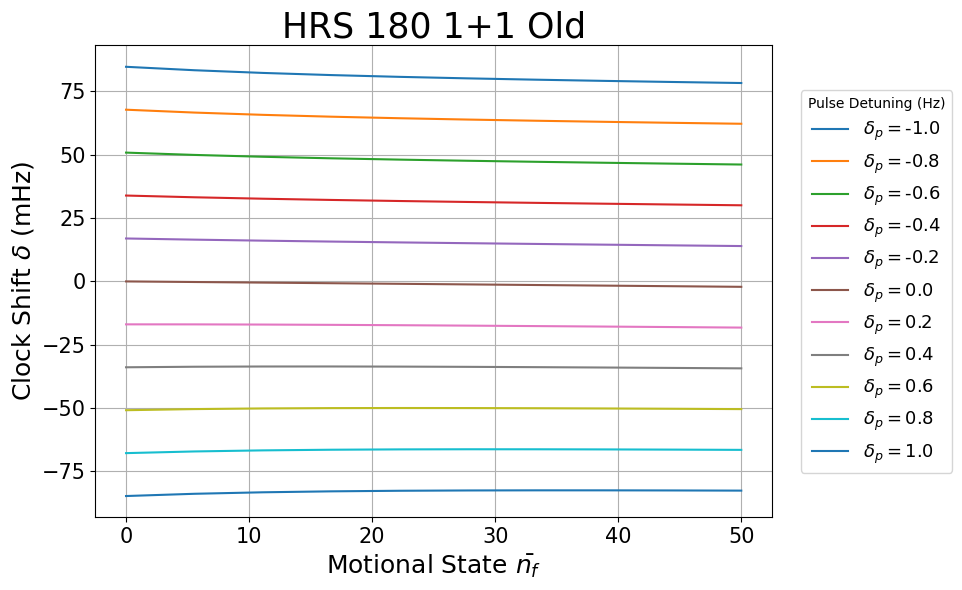

In [63]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+1 Old",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

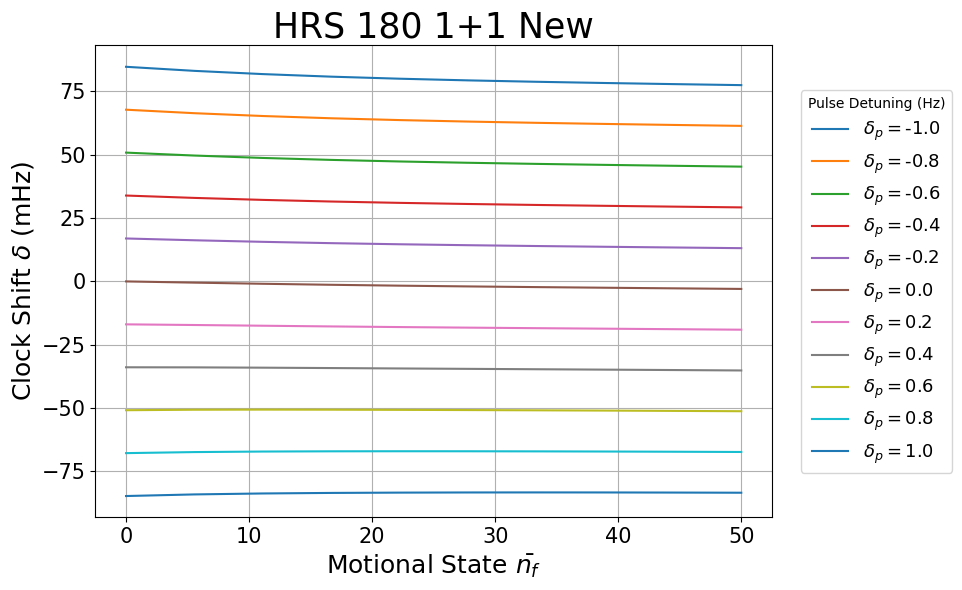

In [64]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results2[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+1 New",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

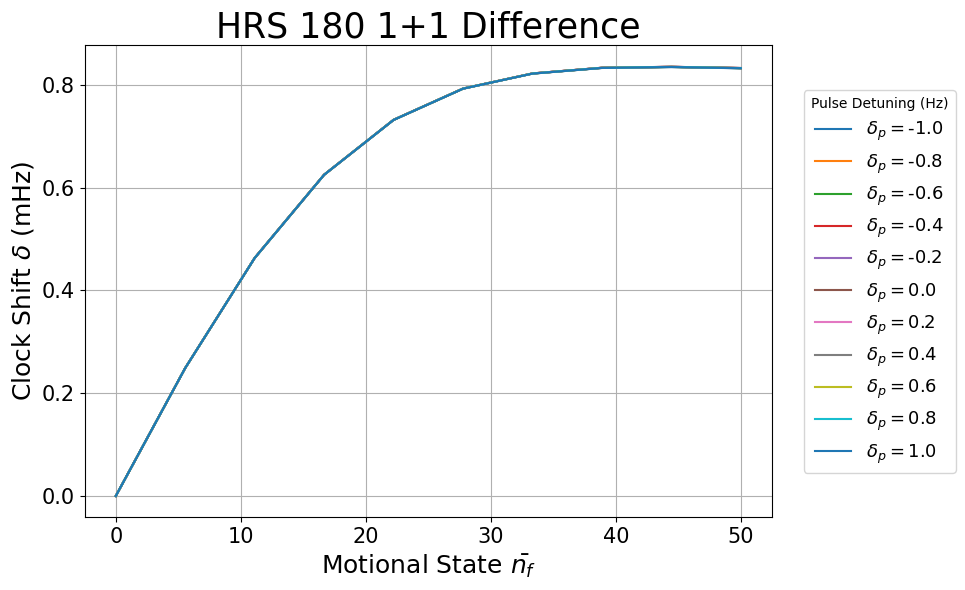

In [65]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*(results[ii,:]-results2[ii,:])/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+1 Difference",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.set_cmap("viridis") 
plt.show()

In [18]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.01,0.01, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])
results2 = np.zeros([delPts, nbarfPts])
results3 = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    #results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    #results2[ii,:] = shiftCurve(HRNew, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results3[ii,:] = shiftCurve(HRNewc, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.00036751134017106867
[-5.000367511340171, 4.999632488659829]
-0.0012124379293005452
[-5.001212437929301, 4.998787562070699]
-0.0020833048569667573
[-5.002083304856967, 4.997916695143033]
-0.0029583463191701666
[-5.00295834631917, 4.99704165368083]
-0.0038234733717545347
[-5.003823473371755, 4.996176526628245]
-0.004670882368026749
[-5.004670882368027, 4.995329117631973]
-0.005497517558767467
[-5.0054975175587675, 4.9945024824412325]
-0.006303724197143807
[-5.006303724197144, 4.993696275802856]
-0.007092147975228842
[-5.007092147975229, 4.992907852024771]
-0.007866866956139952
[-5.00786686695614, 4.99213313304386]
-0.008632749093807311
[-5.008632749093807, 4.991367250906193]
-0.009395027011038089
[-5.009395027011038, 4.990604972988962]
-0.010159068135255571
[-5.0101590681352555, 4.9898409318647445]
-0.010930309143601023
[-5.010930309143601, 4.989069690856399]
-0.011714324655067406
[-5.011714324655068, 4.988285675344932]
-0.012517008945956667
[-5.012517008945957, 4.987482991054043]
-0

-0.0036129367091177244
[-5.003612936709118, 4.996387063290882]
-0.0032312891806994684
[-5.003231289180699, 4.996768710819301]
-0.0027320634061609975
[-5.002732063406161, 4.997267936593839]
-0.0020937837965348516
[-5.002093783796535, 4.997906216203465]
-0.0012879829438160512
[-5.001287982943816, 4.998712017056184]
-0.0002766257249147585
[-5.000276625724915, 4.999723374275085]
0.0009918561665657384
[-4.999008143833434, 5.000991856166566]
0.002588839689144086
[-4.997411160310856, 5.002588839689144]
0.004615787076436996
[-4.995384212923563, 5.004615787076437]
0.007221801282712351
[-4.9927781987172875, 5.0072218012827125]
0.010635223881836471
[-4.989364776118164, 5.010635223881836]
0.01522433586567112
[-4.984775664134329, 5.015224335865671]
0.021624039661717036
[-4.978375960338283, 5.021624039661717]
0.031030631943103897
[-4.9689693680568965, 5.0310306319431035]
0.04599862912463961
[-4.9540013708753605, 5.0459986291246395]
-0.00029040901393684906
[-5.000290409013937, 4.999709590986063]
-0.0

-0.0002287255447334965
[-5.0002287255447335, 4.9997712744552665]
-0.0005311032888908376
[-5.000531103288891, 4.999468896711109]
-0.0007701744740416078
[-5.000770174474042, 4.999229825525958]
-0.0009225400638611463
[-5.000922540063861, 4.999077459936139]
-0.0009716468290461401
[-5.000971646829046, 4.999028353170954]
-0.0009062372555380913
[-5.000906237255538, 4.999093762744462]
-0.000718739609898622
[-5.000718739609899, 4.999281260390101]
-0.0004038443905918214
[-5.000403844390592, 4.999596155609408]
4.2762543851534236e-05
[-4.999957237456148, 5.000042762543852]
0.0006255712308770945
[-4.999374428769123, 5.000625571230877]
0.0013503338822943103
[-4.998649666117705, 5.001350333882295]
0.002225065405312386
[-4.997774934594688, 5.002225065405312]
0.00326098659856221
[-4.996739013401438, 5.003260986598562]
0.0044734756527882655
[-4.995526524347212, 5.004473475652788]
0.005883125312371293
[-4.994116874687629, 5.005883125312371]
0.007517033523224254
[-4.992482966476776, 5.007517033523224]
0.0

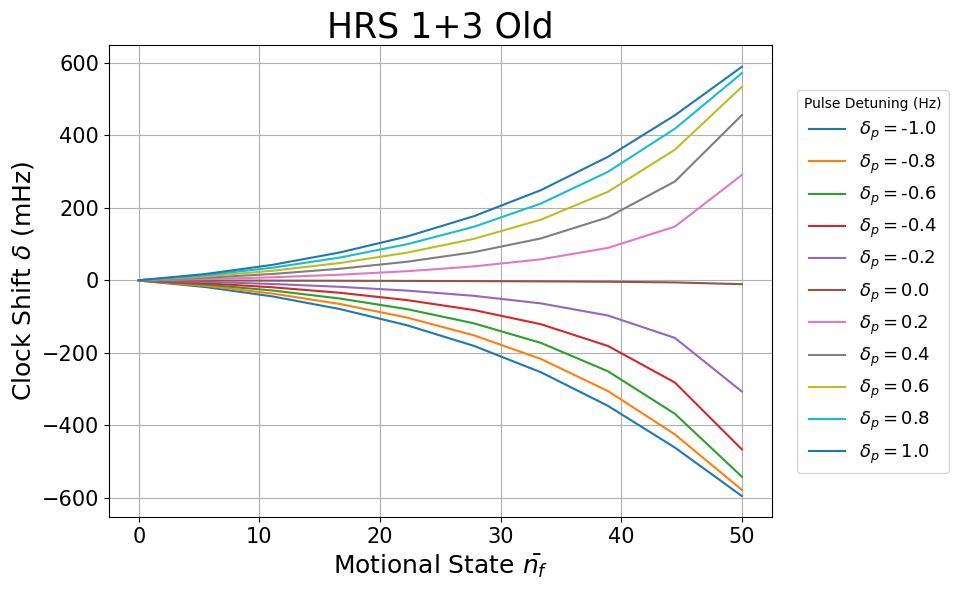

In [101]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+3 Old",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

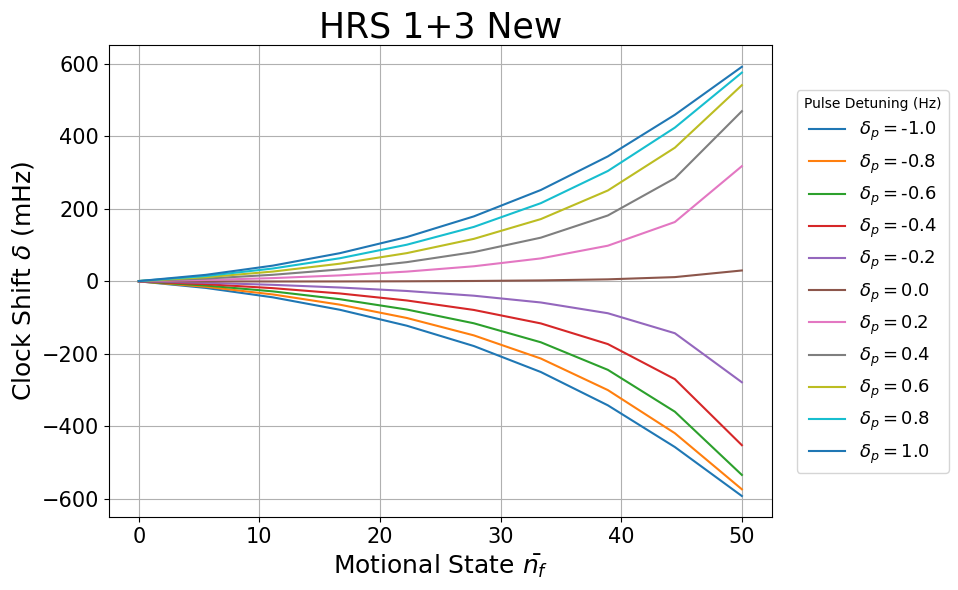

In [102]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results2[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+3 New",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

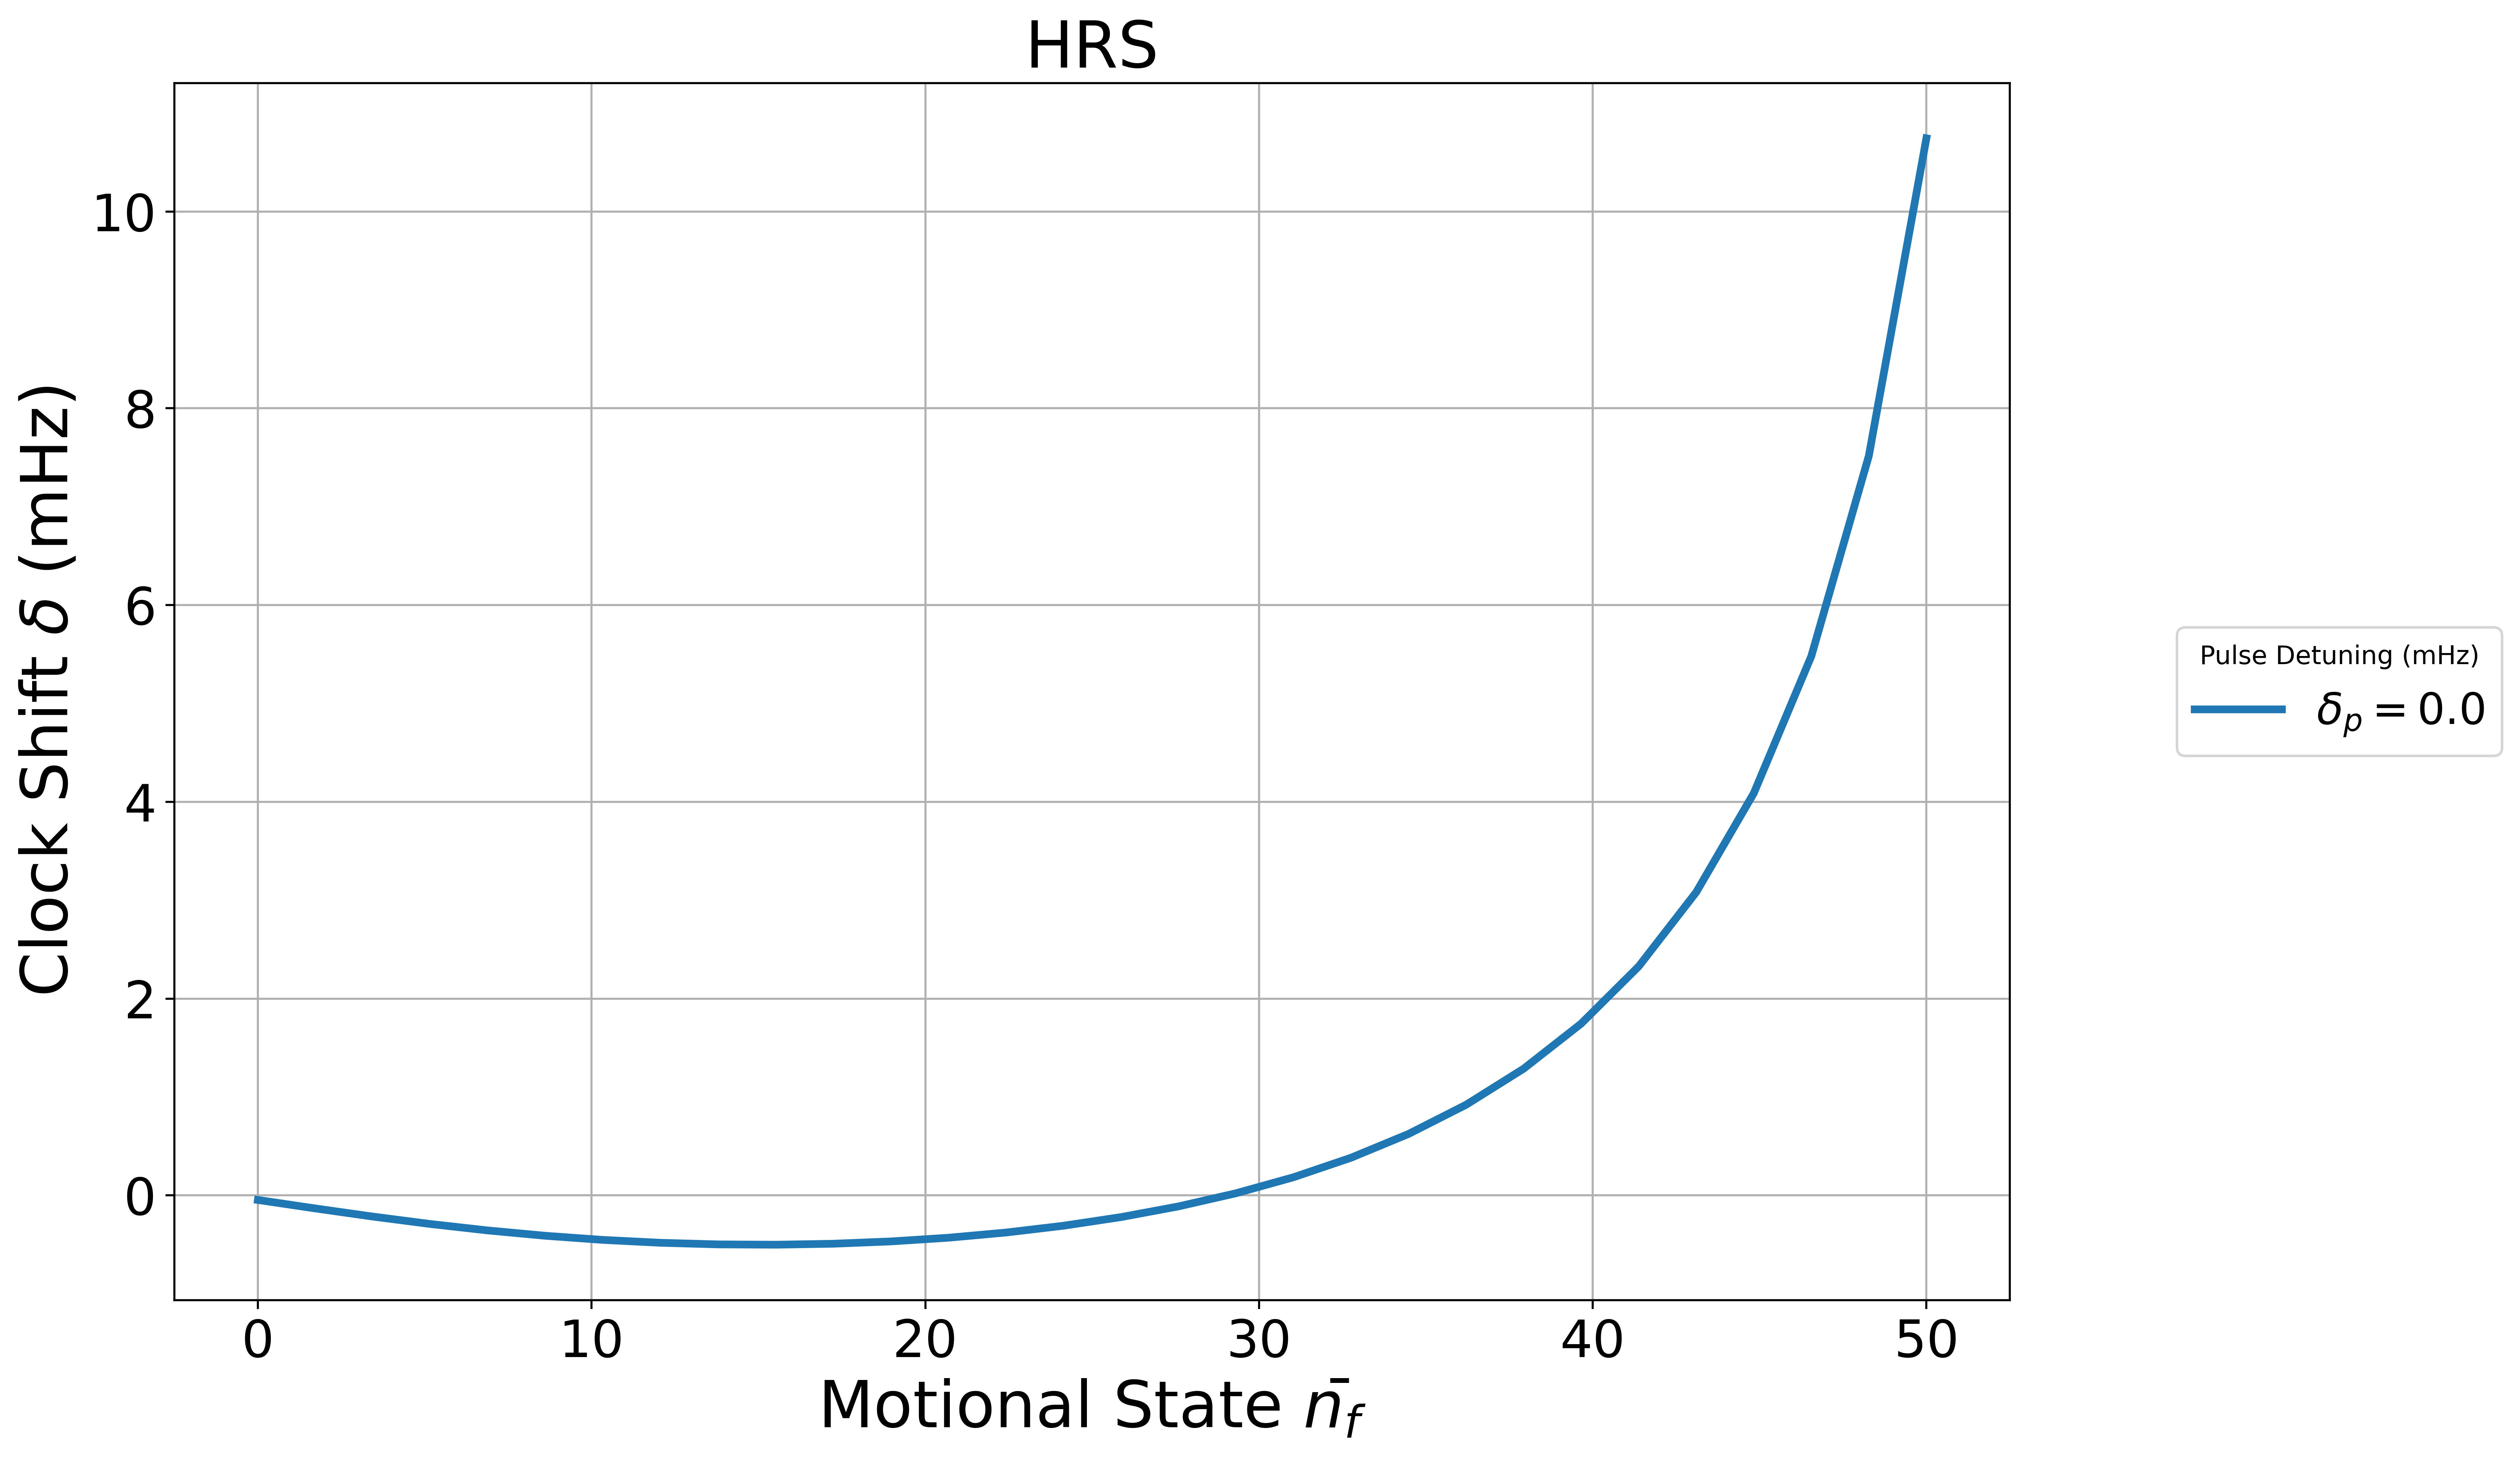

In [31]:
plt.figure(figsize=(14,8), dpi=500)
#for ii in range(6):
plt.plot(nbarfs, 1e3*results3[5,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(1000.*delPrimes[5]/(2.0*np.pi), 1)), linewidth=3)#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="25")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="25")
plt.grid()
plt.xticks(fontsize="20")
plt.yticks(fontsize="20")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right',  title=r"Pulse Detuning (mHz)", fontsize="17")
plt.tight_layout()
plt.show()

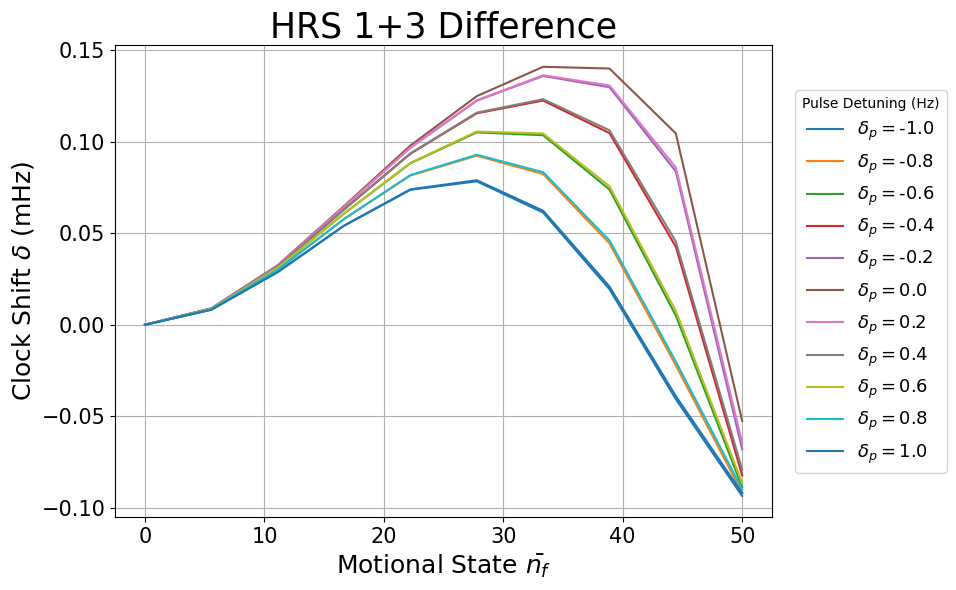

In [104]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*(results[ii,:]-results3[ii,:])/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+3 Difference",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [67]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])
results2 = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 5.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results2[ii,:] = shiftCurve(HRNew, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.5291874041047318
[-4.470812595895268, 5.529187404104732]
0.4744235243933052
[-4.5255764756066945, 5.4744235243933055]
0.5231224745944474
[-4.476877525405553, 5.523122474594447]
0.7360471980961413
[-4.263952801903859, 5.736047198096141]
1.1765408769424177
[-3.8234591230575825, 6.1765408769424175]
1.8213880078826414
[-3.1786119921173586, 6.821388007882641]
2.4885397541410246
[-2.5114602458589754, 7.488539754141025]
2.9812703218894874
[-2.0187296781105126, 7.981270321889488]
3.2581551660412775
[-1.7418448339587225, 8.258155166041277]
3.376505824887169
[-1.623494175112831, 8.376505824887168]
0.5291874041047314
[-4.470812595895269, 5.529187404104731]
0.47390885867820604
[-4.526091141321794, 5.473908858678206]
0.525647355865932
[-4.474352644134068, 5.525647355865932]
0.7445072905105778
[-4.255492709489422, 5.744507290510578]
1.1906553826304493
[-3.8093446173695504, 6.19065538263045]
1.8352574780013253
[-3.164742521998675, 6.835257478001325]
2.4940942510847215
[-2.5059057489152785, 7.494094

-0.2146636425311322
[-5.214663642531132, 4.785336357468868]
-0.3087670975704028
[-5.308767097570403, 4.691232902429597]
-0.5063678021083355
[-5.506367802108335, 4.493632197891665]
-0.8149404322024404
[-5.81494043220244, 4.18505956779756]
-1.1750719928968372
[-6.175071992896838, 3.824928007103163]
-1.4782068680313787
[-6.4782068680313785, 3.5217931319686215]
-1.6587714894523766
[-6.658771489452377, 3.3412285105476234]
-1.7272165515247415
[-6.727216551524742, 3.2727834484752583]
-0.21036498152508362
[-5.210364981525084, 4.789635018474916]
-0.19155964263356084
[-5.19155964263356, 4.80844035736644]
-0.211905019631204
[-5.211905019631204, 4.788094980368796]
-0.2995027380659392
[-5.299502738065939, 4.700497261934061]
-0.4895658516301641
[-5.489565851630164, 4.510434148369836]
-0.7937753651844719
[-5.793775365184472, 4.206224634815528]
-1.1571510201610438
[-6.157151020161043, 3.8428489798389562]
-1.4708565683230317
[-6.470856568323032, 3.5291434316769683]
-1.664696505333438
[-6.66469650533343

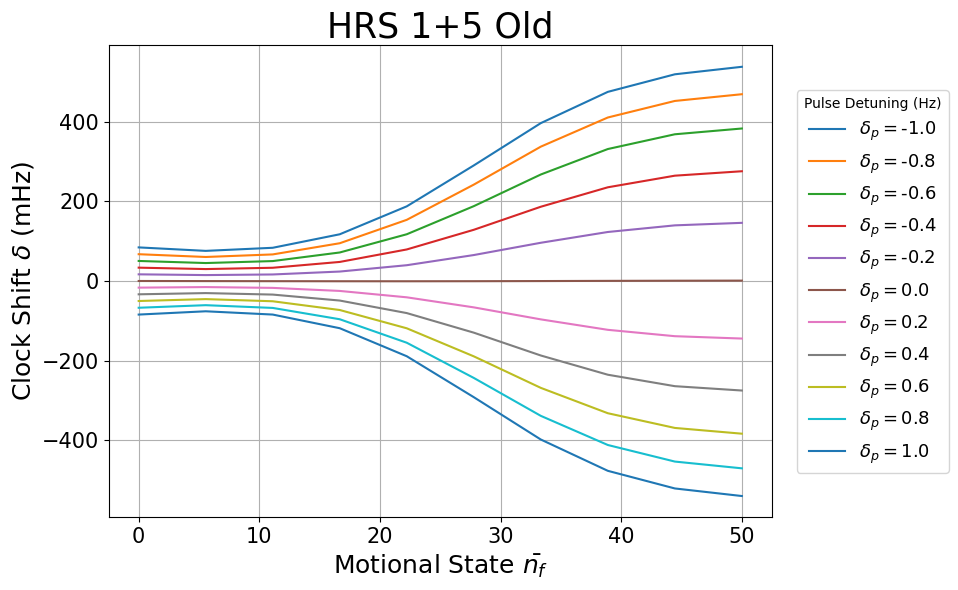

In [73]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+5 Old",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

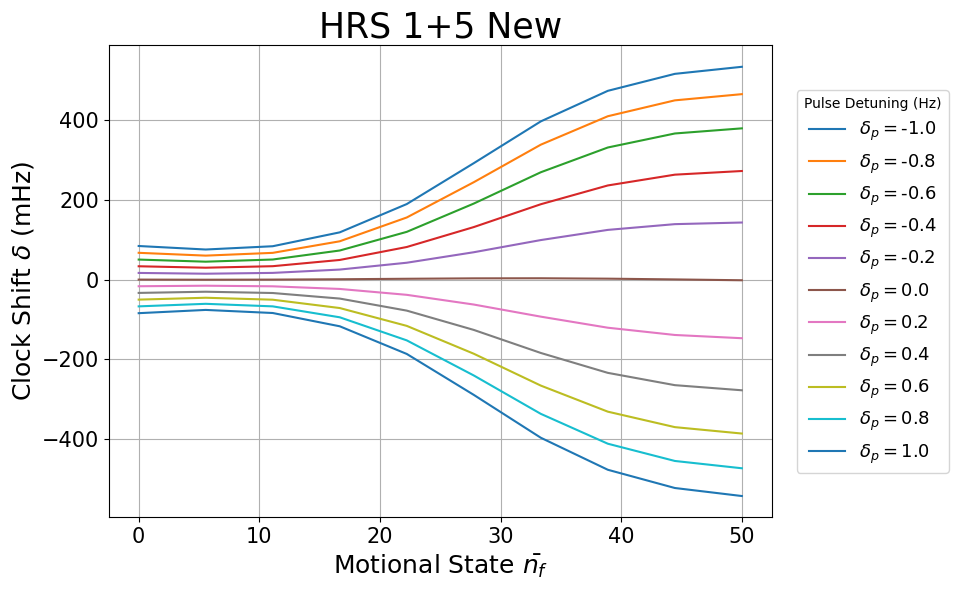

In [72]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results2[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+5 New",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

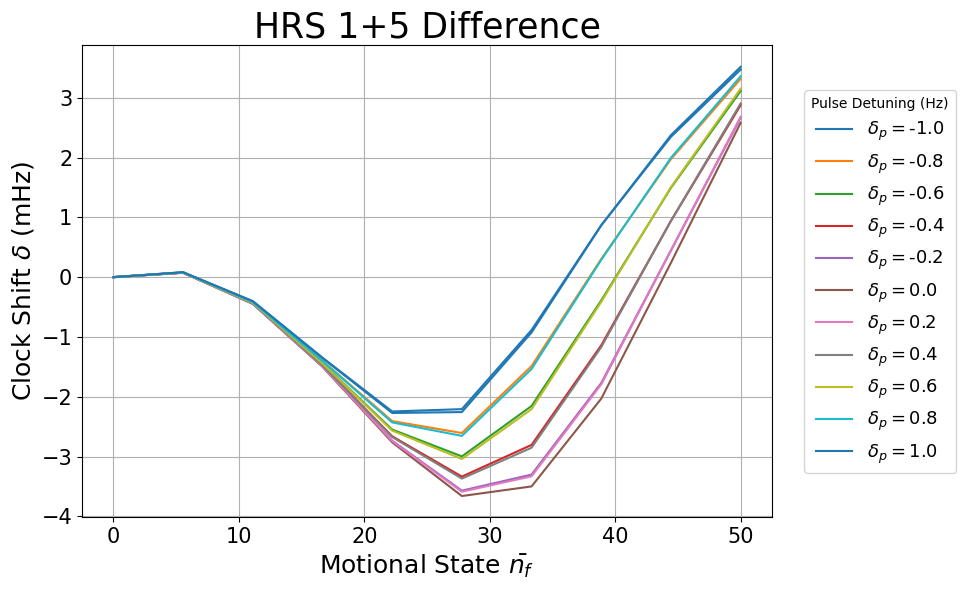

In [71]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*(results[ii,:]-results2[ii,:])/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 1+5 Difference",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [18]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.6,0.0, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])
results2 = np.zeros([delPts, nbarfPts])
results3 = np.zeros([delPts, nbarfPts])
results4 = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results2[ii,:] = shiftCurve(HRJumpNew, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results3[ii,:] = shiftCurve(HRJumpNewb, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results4[ii,:] = shiftCurve(HRJumpNewc, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.0016501473414191055
[-4.998349852658581, 5.001650147341419]
0.004374263347330037
[-4.99562573665267, 5.00437426334733]
0.00595368019090675
[-4.994046319809093, 5.005953680190907]
0.0067029117063092175
[-4.993297088293691, 5.006702911706309]
0.006856168792167571
[-4.993143831207832, 5.006856168792168]
0.006588559567941243
[-4.993411440432059, 5.006588559567941]
0.006026582063818743
[-4.993973417936181, 5.006026582063819]
0.00525731424744217
[-4.994742685752557, 5.005257314247443]
0.004338907359676231
[-4.995661092640324, 5.004338907359676]
0.0033098568692567637
[-4.996690143130743, 5.003309856869257]
0.0016501473414198017
[-4.99834985265858, 5.00165014734142]
0.0028193445750260464
[-4.997180655424974, 5.002819344575026]
0.0030838416894623144
[-4.996916158310538, 5.003083841689462]
0.0028705576821878025
[-4.997129442317812, 5.002870557682188]
0.0024328363069992397
[-4.997567163693001, 5.002432836306999]
0.0018830140805550974
[-4.998116985919445, 5.001883014080555]
0.001249735352311808


-0.007829271499226588
[-5.007829271499227, 4.992170728500773]
0.0005383714631997615
[-4.9994616285368005, 5.0005383714631995]
0.0018449940112509513
[-4.998155005988749, 5.001844994011251]
0.0023748659763321712
[-4.997625134023668, 5.002374865976332]
0.00235039642622996
[-4.99764960357377, 5.00235039642623]
0.0019331354728234684
[-4.998066864527177, 5.001933135472823]
0.0012404763489664724
[-4.998759523651033, 5.001240476348967]
0.00035519265505364945
[-4.999644807344946, 5.000355192655054]
-0.0006665403064356088
[-5.000666540306436, 4.999333459693564]
-0.0017873185107456374
[-5.001787318510746, 4.998212681489254]
-0.002982191685168367
[-5.0029821916851684, 4.9970178083148316]
0.0005383714632002056
[-4.9994616285368, 5.0005383714632]
0.0018717489588497675
[-4.99812825104115, 5.00187174895885]
0.002543176787011761
[-4.997456823212988, 5.002543176787012]
0.0028303629445570275
[-4.997169637055443, 5.002830362944557]
0.0029044946729611487
[-4.997095505327039, 5.002904494672961]
0.0028527649

-1.6582948941460944e-05
[-5.000016582948941, 4.999983417051059]
-0.00033671278558427165
[-5.000336712785584, 4.999663287214416]
-0.0007914601187631286
[-5.000791460118763, 4.999208539881237]
-0.0012802982550176932
[-5.0012802982550175, 4.9987197017449825]
-0.0017686950793242104
[-5.001768695079324, 4.998231304920676]
-0.002259111872478075
[-5.002259111872478, 4.997740888127522]
-0.0027643071513346836
[-5.002764307151335, 4.997235692848665]
-0.003293885918536905
[-5.003293885918537, 4.996706114081463]
-0.0038509053070829033
[-5.0038509053070825, 4.9961490946929175]
-0.00011416944744354283
[-5.000114169447444, 4.999885830552556]
-0.0005828868976957667
[-5.000582886897695, 4.999417113102305]
-0.0013830060287465216
[-5.001383006028746, 4.998616993971254]
-0.0024201354231668582
[-5.002420135423167, 4.997579864576833]
-0.003625884988439408
[-5.003625884988439, 4.996374115011561]
-0.004950070721645156
[-5.004950070721645, 4.995049929278355]
-0.00635680571622452
[-5.006356805716225, 4.99364319

-0.007251072162546982
[-5.007251072162547, 4.992748927837453]
-0.008985436436884126
[-5.008985436436884, 4.991014563563116]
-0.010718900206420643
[-5.01071890020642, 4.98928109979358]
-0.012451680945909219
[-5.012451680945909, 4.987548319054091]
-0.014183903227727475
[-5.014183903227727, 4.985816096772273]
-0.015915647360089994
[-5.01591564736009, 4.98408435263991]
-0.000290409013937088
[-5.000290409013937, 4.999709590986063]
-0.003589295487985161
[-5.003589295487985, 4.996410704512015]
-0.006639586168881799
[-5.006639586168882, 4.993360413831118]
-0.009332532096477027
[-5.009332532096477, 4.990667467903523]
-0.011651345134390298
[-5.01165134513439, 4.98834865486561]
-0.013659871142852463
[-5.013659871142853, 4.986340128857147]
-0.015456363836009016
[-5.015456363836009, 4.984543636163991]
-0.017129552570307703
[-5.0171295525703075, 4.9828704474296925]
-0.018740687910127677
[-5.018740687910127, 4.981259312089873]
-0.020323898825670865
[-5.020323898825671, 4.979676101174329]
-0.000290409

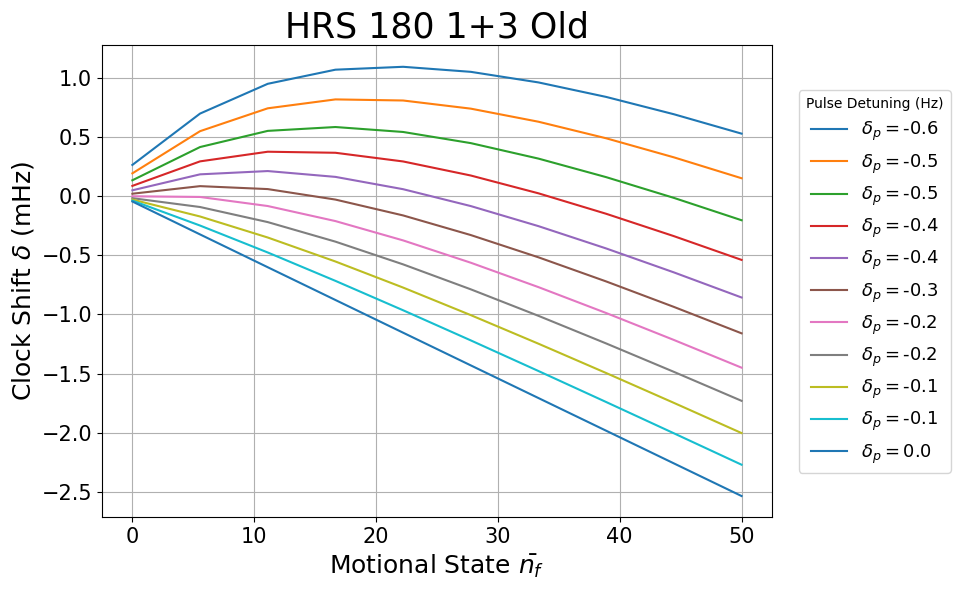

In [21]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+3 Old",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

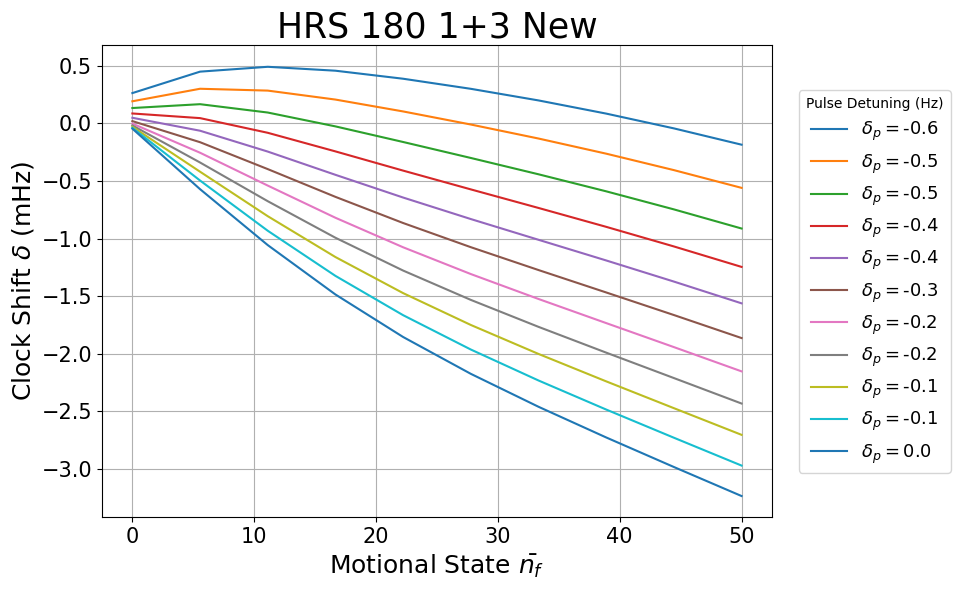

In [13]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results2[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+3 New",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

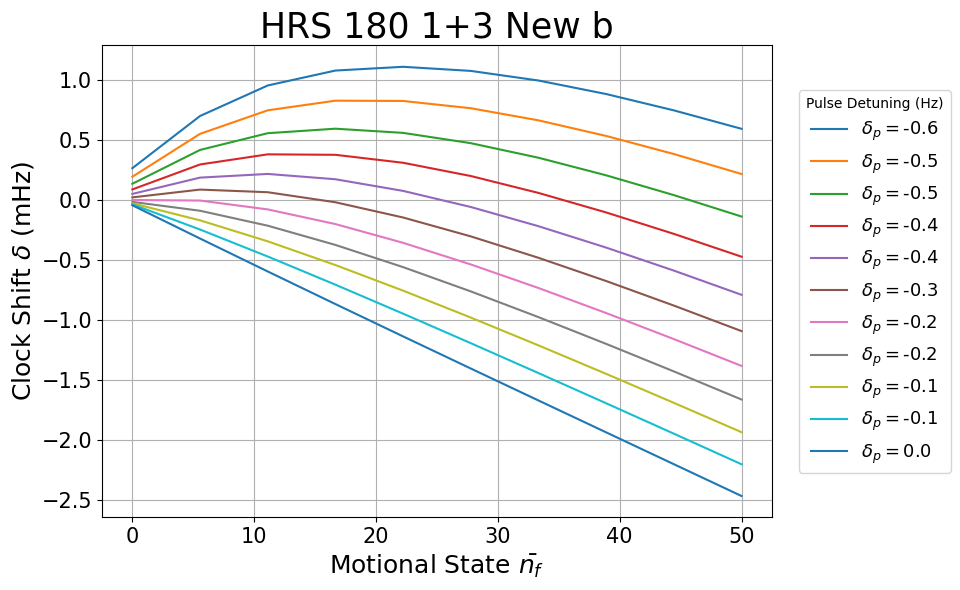

In [14]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results3[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+3 New b",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

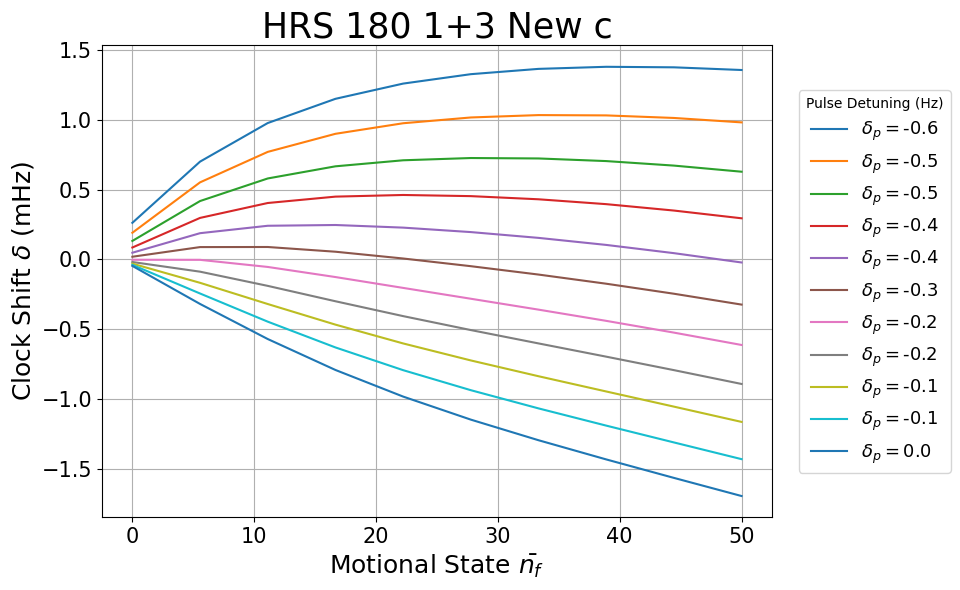

In [19]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results4[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+3 New c",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

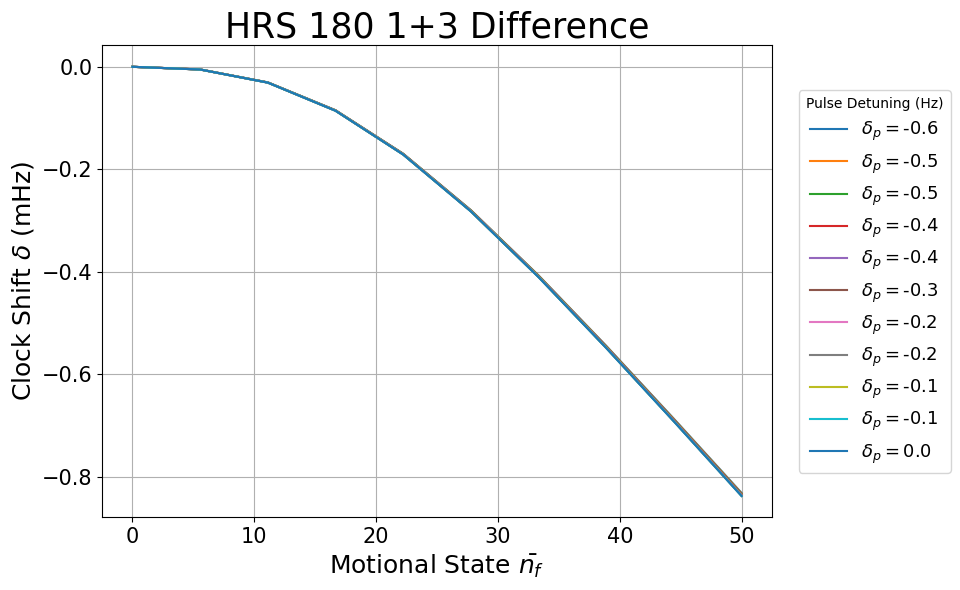

In [20]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*(results[ii,:]-results4[ii,:])/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+3 Difference",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [95]:
def HRJumpFullHeat(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    intState = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        phi = dopAndStarks[n]*T
        delp1 = del1 + dopAndStarks[n] - dopAndStarks[0]
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        intState[n,:] = subPulse(T, 0.0, deld, 0.0, phi)@subPulse(t1, Omega0*omegas[n], delp1, 0.0, 0.0)@psi0
        psiP[n,:] = subPulse(t2/3.0, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(2.*t2/3., -Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(0.,0.,0.,0.,np.pi/2.0)@intState[n,:]
        psiM[n,:] = subPulse(t2/3.0, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(2.*t2/3., -Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(0.,0.,0.,0.,-np.pi/2.0)@intState[n,:]
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

In [96]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])
results2 = np.zeros([delPts, nbarfPts])
results3 = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results2[ii,:] = shiftCurve(HRJumpNew, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results3[ii,:] = shiftCurve(HRJumpFullHeat, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)


0.007282862676294447
[-4.992717137323705, 5.007282862676295]
0.01365655747712414
[-4.986343442522876, 5.013656557477124]
0.018027204156537573
[-4.981972795843462, 5.018027204156538]
0.020906329778953302
[-4.979093670221046, 5.020906329778954]
0.022696908856778737
[-4.977303091143221, 5.022696908856779]
0.02371146401596997
[-4.97628853598403, 5.02371146401597]
0.024180301500673917
[-4.975819698499326, 5.024180301500674]
0.02426354892015288
[-4.975736451079847, 5.024263548920153]
0.0240686774203167
[-4.975931322579683, 5.024068677420317]
0.023667017519643216
[-4.976332982480357, 5.023667017519643]
0.007282862676295001
[-4.992717137323705, 5.007282862676295]
0.012097540485528777
[-4.987902459514471, 5.012097540485529]
0.015143549351551022
[-4.984856450648449, 5.015143549351551]
0.017047655091018313
[-4.982952344908981, 5.017047655091019]
0.01823385170191049
[-4.98176614829809, 5.01823385170191]
0.018952487072246955
[-4.981047512927753, 5.018952487072247]
0.019336022407052463
[-4.980663977

-0.00023501434465460103
[-5.000235014344654, 4.999764985655346]
-0.003347007173364401
[-5.003347007173365, 4.996652992826635]
-0.006055937650407481
[-5.006055937650408, 4.993944062349592]
-0.008269219369406102
[-5.0082692193694065, 4.9917307806305935]
-0.01004209878595201
[-5.010042098785952, 4.989957901214048]
-0.011478262719390085
[-5.01147826271939, 4.98852173728061]
-0.01268214473609134
[-5.012682144736091, 4.987317855263909]
-0.013738909994010248
[-5.01373890999401, 4.98626109000599]
-0.014709459627852249
[-5.014709459627852, 4.985290540372148]
-0.015633061346421753
[-5.0156330613464215, 4.9843669386535785]
-0.0002904090139375235
[-5.000290409013938, 4.999709590986062]
-0.0020367268817245675
[-5.002036726881725, 4.997963273118275]
-0.003777709723065595
[-5.003777709723066, 4.996222290276934]
-0.0055154064708494484
[-5.00551540647085, 4.99448459352915]
-0.007251072162546982
[-5.007251072162547, 4.992748927837453]
-0.008985436436884126
[-5.008985436436884, 4.991014563563116]
-0.0107

-0.023885333396666535
[-5.023885333396667, 4.976114666603333]
-0.02825040496238067
[-5.028250404962381, 4.971749595037619]
-0.032024123097950545
[-5.03202412309795, 4.96797587690205]
-0.035383167484346986
[-5.035383167484347, 4.964616832515653]
-0.03844956981014017
[-5.03844956981014, 4.96155043018986]
-0.04130496147848693
[-5.041304961478487, 4.958695038521513]
-0.04400344571010167
[-5.044003445710102, 4.955996554289898]
-0.004405025221071341
[-5.004405025221072, 4.995594974778928]
-0.013889346718582747
[-5.0138893467185826, 4.9861106532814174]
-0.02156174886729895
[-5.021561748867299, 4.978438251132701]
-0.027728579583272406
[-5.027728579583273, 4.972271420416727]
-0.03269002055498915
[-5.032690020554989, 4.967309979445011]
-0.0367513836899128
[-5.0367513836899125, 4.9632486163100875]
-0.040187157612310336
[-5.04018715761231, 4.95981284238769]
-0.04320791920355575
[-5.043207919203556, 4.956792080796444]
-0.045956397187811596
[-5.045956397187812, 4.954043602812188]
-0.0485206607935006

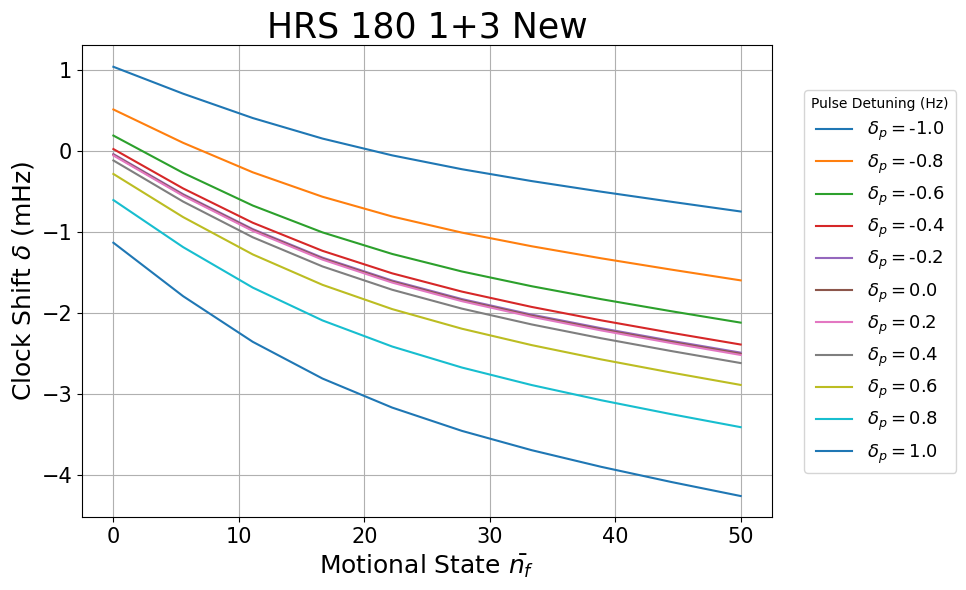

In [97]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results3[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+3 New",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

# Attempting Final Plots!!

In [8]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.6,0.0, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpNewc, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.0016501473414198017
[-4.99834985265858, 5.00165014734142]
0.0044066892674989935
[-4.995593310732501, 5.004406689267499]
0.006144609571636223
[-4.993855390428363, 5.006144609571637]
0.007234936003635085
[-4.992765063996365, 5.007234936003635]
0.007921008737884731
[-4.992078991262115, 5.007921008737885]
0.008345278482734923
[-4.991654721517265, 5.008345278482735]
0.00858370403677161
[-4.991416295963228, 5.008583704036772]
0.008677689567384381
[-4.991322310432616, 5.008677689567384]
0.008653876867504785
[-4.991346123132495, 5.008653876867505]
0.008533239643597607
[-4.991466760356403, 5.008533239643597]
0.001202877683545233
[-4.9987971223164545, 5.0012028776835455]
0.003473184219886381
[-4.996526815780114, 5.003473184219886]
0.00484539198250469
[-4.995154608017495, 5.004845391982505]
0.005659672135137722
[-4.994340327864863, 5.005659672135137]
0.0061351055146932
[-4.993864894485307, 5.006135105514693]
0.006395366151480738
[-4.993604633848519, 5.006395366151481]
0.00650258696618592
[-4.99

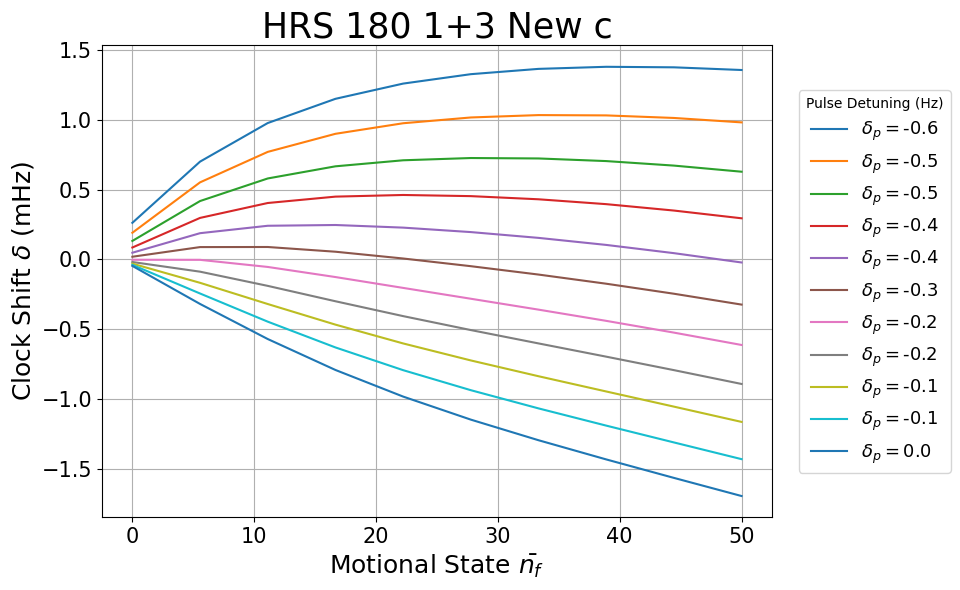

In [10]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+3 New c",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [8]:
delPts = 6
delPrimes = 2.0*np.pi*np.linspace(-0.5,-0.,delPts)
nbarfPts = 25
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*t1)
Ncut = 500

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpNewc, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.0009494206852062887
[-4.999050579314794, 5.000949420685206]
0.0018036120456977815
[-4.9981963879543025, 5.0018036120456975]
0.002506341656467356
[-4.997493658343533, 5.002506341656467]
0.0030812409446218446
[-4.9969187590553785, 5.0030812409446215]
0.0035490258954337236
[-4.996450974104566, 5.003549025895434]
0.003927674265082304
[-4.996072325734918, 5.003927674265082]
0.00423264950472892
[-4.995767350495271, 5.004232649504729]
0.004477085991873029
[-4.995522914008127, 5.004477085991873]
0.004671923460758405
[-4.995328076539241, 5.004671923460759]
0.004826044078996092
[-4.995173955921004, 5.004826044078996]
0.004946457039056254
[-4.995053542960944, 5.004946457039056]
0.00503853340874881
[-4.994961466591251, 5.005038533408749]
0.005106267342038703
[-4.994893732657961, 5.005106267342039]
0.005152535983257181
[-4.994847464016742, 5.005152535983258]
0.00517933824473424
[-4.9948206617552655, 5.0051793382447345]
0.005188002360915347
[-4.994811997639085, 5.005188002360915]
0.005179359517994

-0.004976480563528976
[-5.004976480563529, 4.995023519436471]
-0.005447670365883295
[-5.005447670365883, 4.994552329634117]
-0.005892409023464603
[-5.005892409023464, 4.994107590976536]
-0.006312789457654203
[-5.006312789457654, 4.993687210542346]
-0.006711448198355411
[-5.006711448198355, 4.993288551801645]
-0.007091358164891889
[-5.0070913581648915, 4.9929086418351085]
-0.007455648541272889
[-5.0074556485412725, 4.9925443514587275]
-0.007807461601603244
[-5.007807461601603, 4.992192538398397]
-0.008149846252357196
[-5.0081498462523575, 4.9918501537476425]
-0.008485683329211749
[-5.008485683329212, 4.991514316670788]
-0.008817636319908716
[-5.008817636319908, 4.991182363680092]
-0.009148121522299947
[-5.0091481215223, 4.9908518784777]
-0.009479292643323645
[-5.009479292643324, 4.990520707356676]
-0.009813035947747252
[-5.009813035947747, 4.990186964052253]
-0.0101509730352097
[-5.01015097303521, 4.98984902696479]
-0.010494469087556224
[-5.010494469087556, 4.989505530912444]
-0.0108446

In [9]:
delPrime = -2.0*np.pi*0.297
nbarfPts = 25
nbarfs = np.linspace(0, 50, nbarfPts)

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 500

optResult = shiftCurve(HRJumpNewc, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncut)

0.00011498374590684257
[-4.999885016254093, 5.000114983745907]
0.0003374987003651052
[-4.9996625012996345, 5.0003374987003655]
0.0004751389795191406
[-4.999524861020481, 5.000475138979519]
0.0005443748543796051
[-4.999455625145621, 5.000544374854379]
0.0005593796652069046
[-4.999440620334793, 5.000559379665207]
0.0005322266868988473
[-4.999467773313101, 5.000532226686899]
0.0004730889498251502
[-4.999526911050175, 5.000473088949825]
0.0003903623988064299
[-4.999609637601194, 5.000390362398806]
0.0002907246312360722
[-4.9997092753687635, 5.0002907246312365]
0.00017921061272780614
[-4.999820789387273, 5.000179210612727]
5.935917795736715e-05
[-4.999940640822043, 5.000059359177957]
-6.657420516644139e-05
[-5.000066574205166, 4.999933425794834]
-0.00019737285239687993
[-5.000197372852397, 4.999802627147603]
-0.0003326169254178015
[-5.000332616925418, 4.999667383074582]
-0.0004724663263057045
[-5.000472466326306, 4.999527533673694]
-0.0006174781372395874
[-5.000617478137239, 4.9993825218627

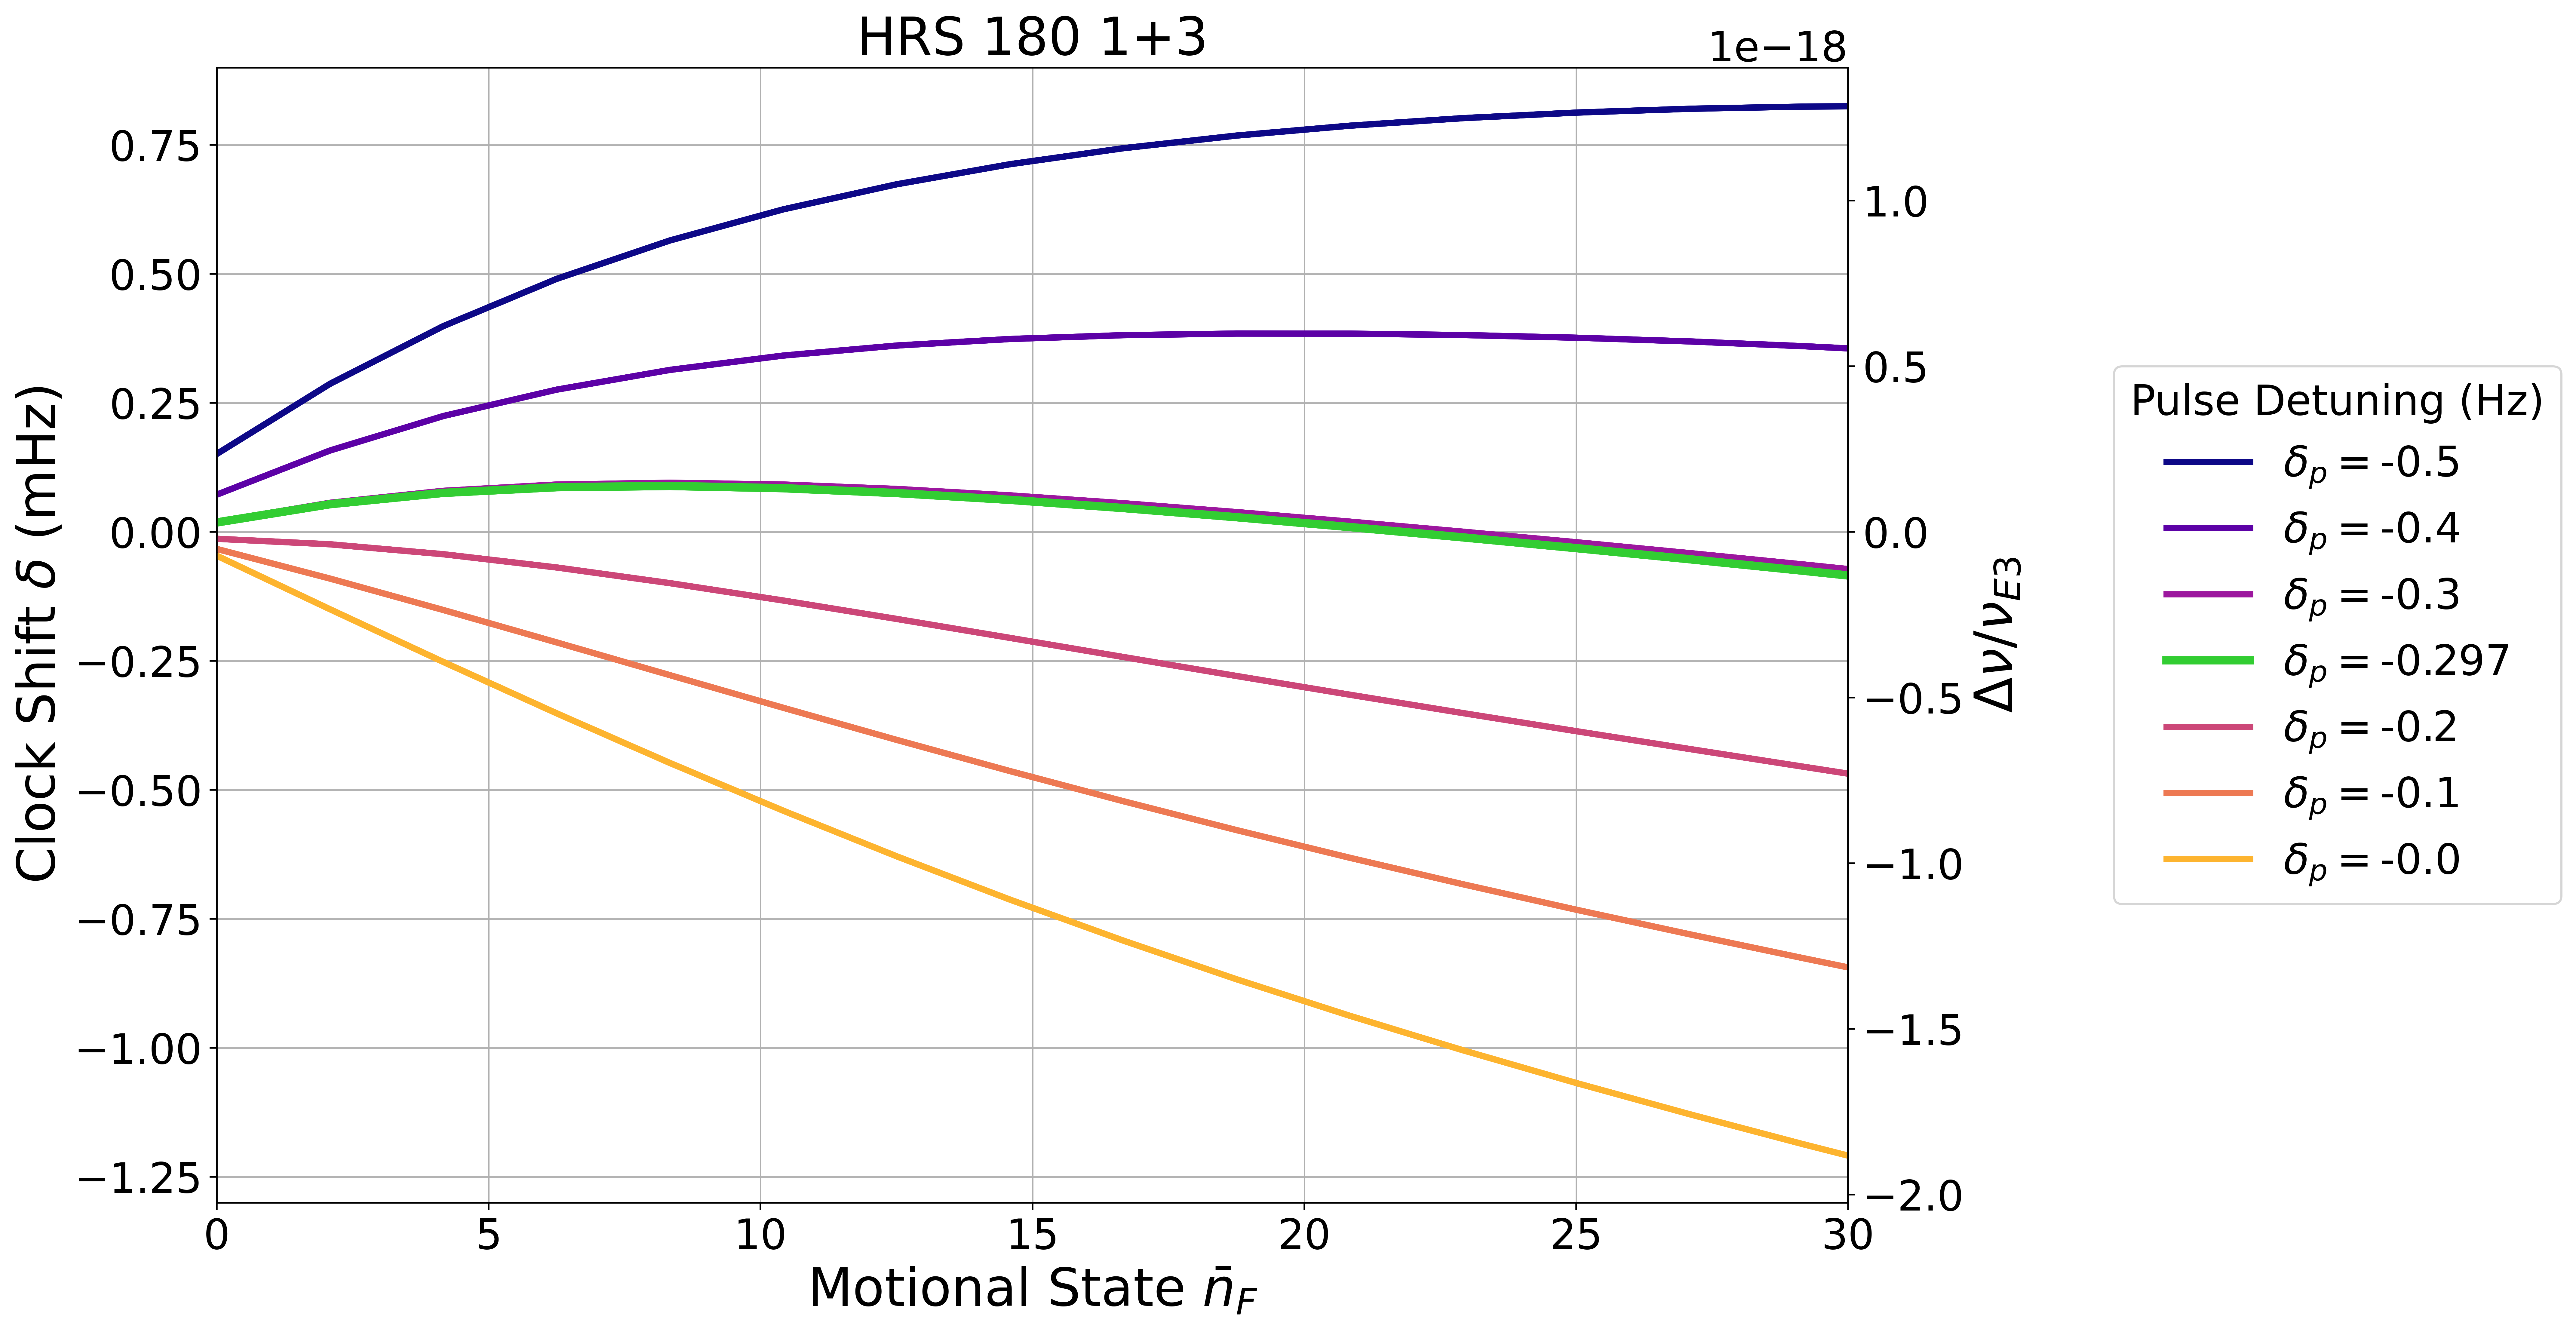

In [10]:
cm=plt.get_cmap('plasma',delPts+1)

fig,ax1=plt.subplots(figsize=(14,10), dpi=500)
#plt.figure(figsize=(14,8), dpi=500)
ax1.set_xlabel(r"Motional State $\bar{n}_F$",fontsize="25")
ax1.set_ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="25")
ax1.set_ylim(-1.3,0.9)
plt.xlim([0,30])
ax1.tick_params(axis="x", labelsize=20)
ax1.grid(axis='y', which='major', linewidth=0.7)
ax1.grid(axis='x', which='major', linewidth=0.7)
ax1.tick_params(axis="y", labelsize="20")
ax2 = ax1.twinx()
ax2.set_ylabel(r"$\Delta \nu/\nu_{E3}$",fontsize="25")
ax2.tick_params(axis="y", labelsize="20")
ax2.set_ylim(-1.3e-3/642121496772645.13, 0.9e-3/642121496772645.13)
ax2.yaxis.offsetText.set_fontsize(20)
for ii in range(3):
    ax1.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), color=cm(ii),linewidth=3, label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))
    ax2.plot(nbarfs, results[ii,:]/(2.0*np.pi*642121496772645.13),linewidth=3,color=cm(ii),label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))

ax1.plot(nbarfs, 1e3*optResult/(2.0*np.pi), label=r"$\delta_p = $" + str(-0.297), color='limegreen',linewidth=4)
ax2.plot(nbarfs, optResult/(2.0*np.pi*642121496772645.13), label=r"$\delta_p = $" + str(-0.297), color='limegreen',linewidth=4)

for ii in range(3,6):
    ax1.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)), color=cm(ii),linewidth=3)
    ax2.plot(nbarfs, results[ii,:]/(2.0*np.pi*642121496772645.13), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)), color=cm(ii),linewidth=3)
    
plt.title("HRS 180 1+3",fontsize="25")
plt.legend( fontsize="20", title=r"Pulse Detuning (Hz)", title_fontsize="20", bbox_to_anchor = (1.45,0.5), loc='center right')
#plt.tight_layout()
plt.set_cmap("viridis")
#plt.ylim([-1.3,0.9])
plt.show()

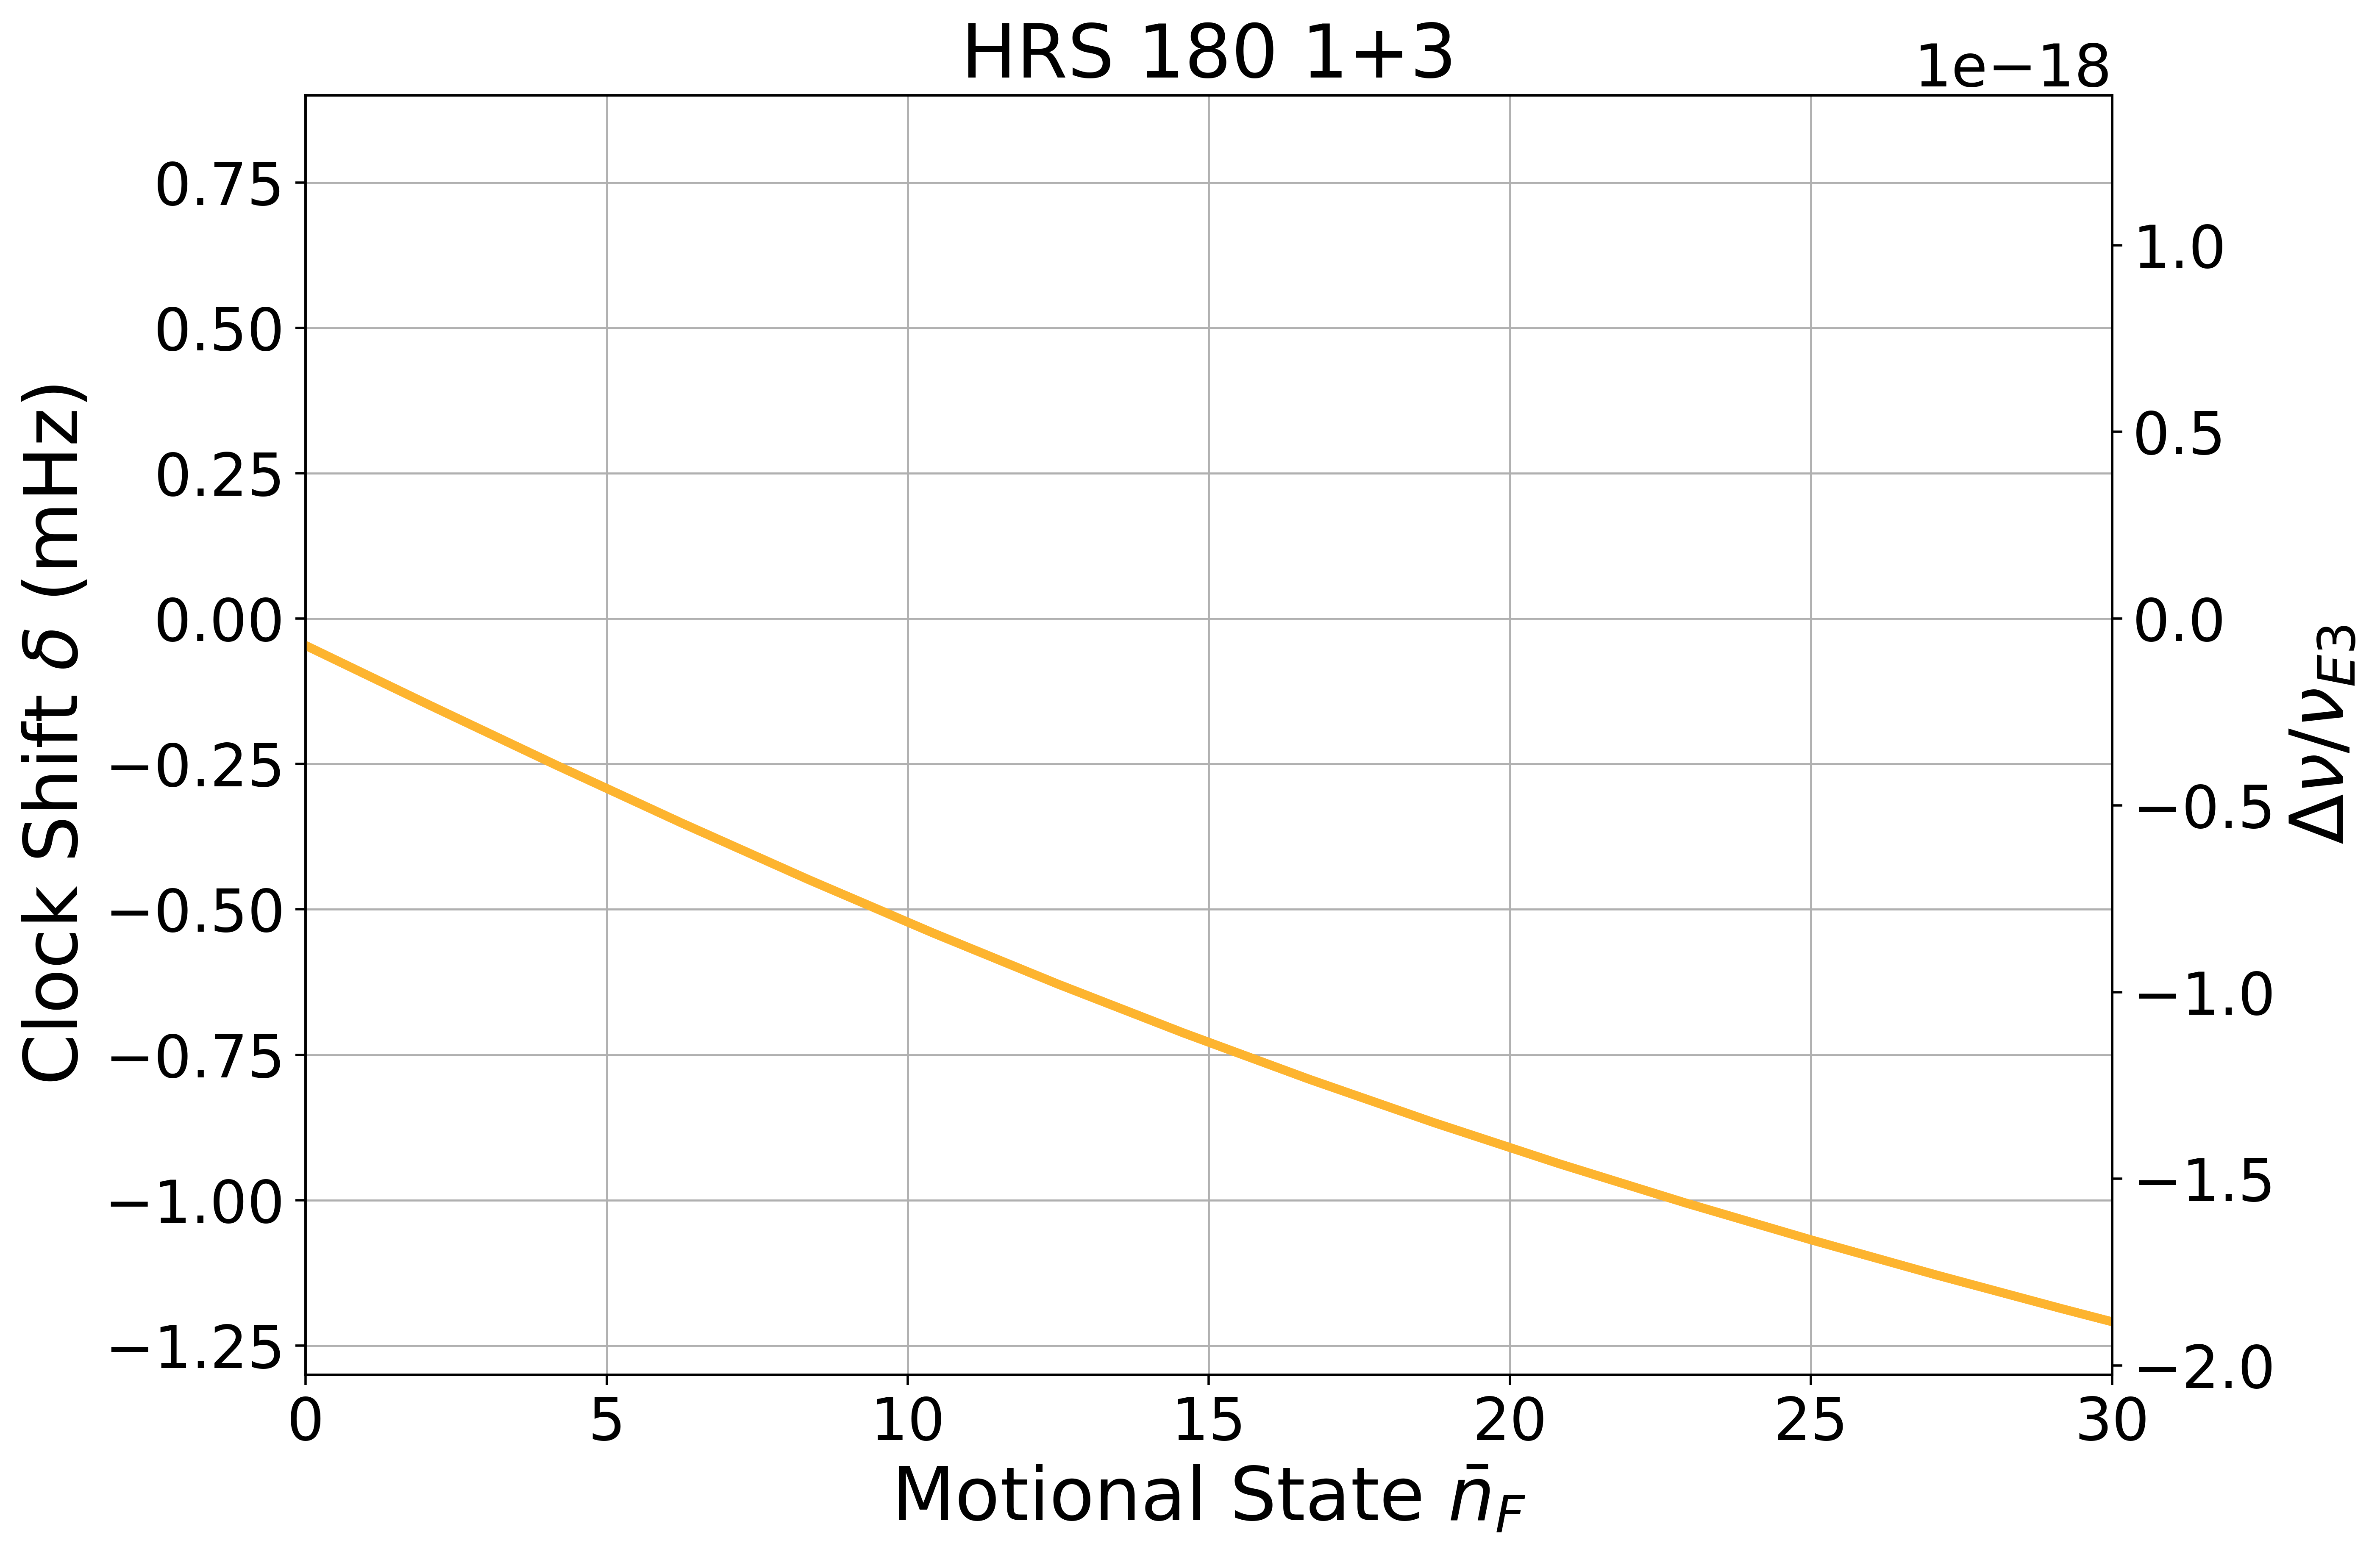

In [11]:
cm=plt.get_cmap('plasma',delPts+1)

fig,ax1=plt.subplots(figsize=(11,8), dpi=500)
#plt.figure(figsize=(14,8), dpi=500)
#for ii in range(3):
ax1.set_xlabel(r"Motional State $\bar{n}_F$",fontsize="25")
ax1.set_ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="25")
ax1.plot(nbarfs, 1e3*results[5,:]/(2.0*np.pi), color=cm(5),linewidth=3, label="test1") #r"$\delta_p = $" + str(round(delPrimes[5]/(2.0*np.pi), 2))
ax1.tick_params(axis="y", labelsize="20")
ax1.set_ylim(-1.3,0.9)
ax1.grid(axis='y', which='major', linewidth=0.7)
ax1.grid(axis='x', which='major', linewidth=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel(r"$\Delta \nu/\nu_{E3}$",fontsize="25")
ax2.plot(nbarfs, results[5,:]/(2.0*np.pi*642121496772645.13),linewidth=3,color=cm(5),label="test2")
ax2.tick_params(axis="y", labelsize="20")
ax2.set_ylim(-1.3e-3/642121496772645.13, 0.9e-3/642121496772645.13)
ax2.yaxis.offsetText.set_fontsize(20)

#ax.plot(nbarfs, 1e3*optResult/(2.0*np.pi), label=r"$\delta_p = $" + str(-0.297), color='limegreen',linewidth=4)

#for ii in range(3,6):
#    ax.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)), color=cm(ii),linewidth=3)
plt.title("HRS 180 1+3",fontsize="25")


#plt.legend( fontsize="18", title=r"Pulse Detuning (Hz)", title_fontsize="18")#bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="18", title=r"Pulse Detuning (Hz)", title_fontsize="18")
#plt.tight_layout()
plt.set_cmap("viridis")
ax1.tick_params(axis="x", labelsize=20)
#plt.ylim([-1.3,0.9])
plt.xlim([0,30])
plt.show()

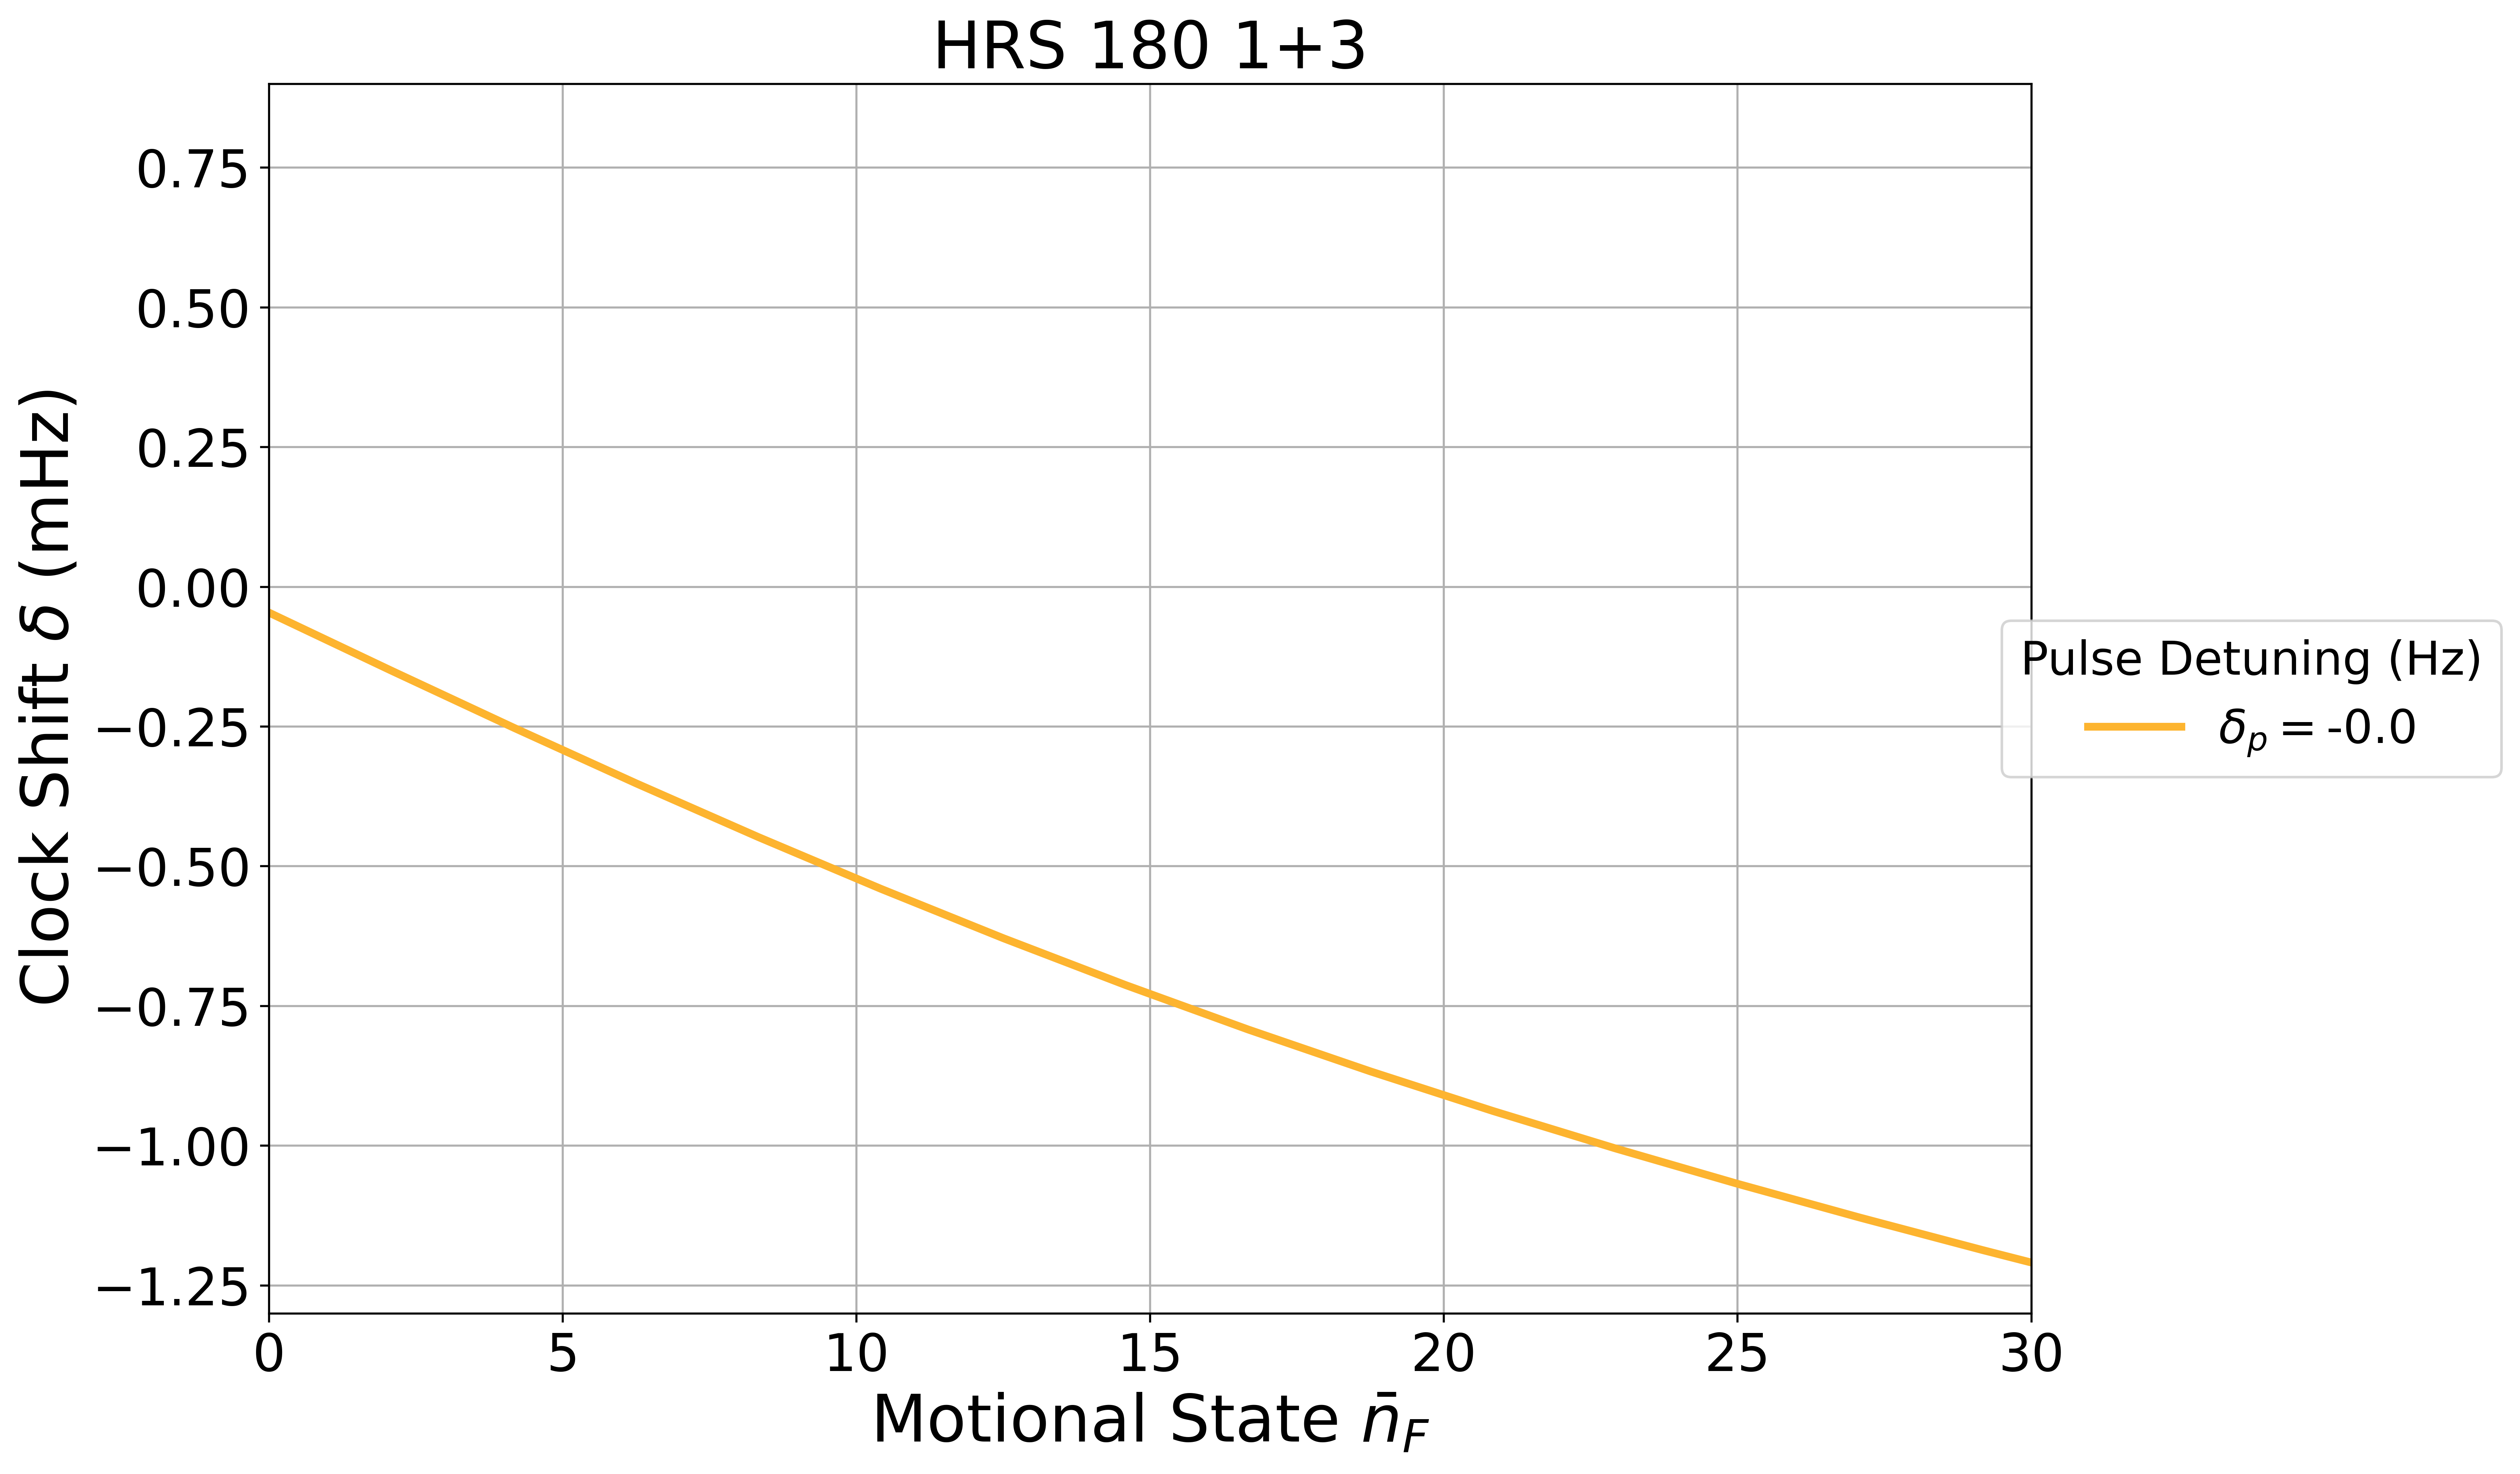

1.7259788570010237

In [53]:
cm=plt.get_cmap('plasma',delPts+1)


plt.figure(figsize=(14,8), dpi=500)
#for ii in range(3):
plt.plot(nbarfs, 1e3*results[5,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[5]/(2.0*np.pi), 2)), color=cm(5),linewidth=3)

#plt.plot(nbarfs, 1e3*optResult/(2.0*np.pi), label=r"$\delta_p = $" + str(-0.297), color='limegreen',linewidth=4)

#for ii in range(3,6):
#    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)), color=cm(ii),linewidth=3)
plt.title("HRS 180 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="25")
plt.xlabel(r"Motional State $\bar{n}_F$",fontsize="25")
plt.xticks(fontsize="20")
plt.yticks(fontsize="20")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="18", title=r"Pulse Detuning (Hz)", title_fontsize="18")
plt.tight_layout()
plt.set_cmap("viridis")
plt.ylim([-1.3,0.9])
plt.xlim([0,30])
plt.grid()
plt.show()

np.max(np.abs(1e3*results/(2.*np.pi)))

In [9]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.30,-0.29,delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 30, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*t1)
Ncut = 500

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJumpNewc, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.00012278995872924998
[-4.999877210041271, 5.000122789958729]
0.0004509926275136745
[-4.999549007372487, 5.000450992627513]
0.0005848287164735826
[-4.999415171283527, 5.000584828716473]
0.0005838703878729857
[-4.999416129612127, 5.000583870387873]
0.000493924905902629
[-4.999506075094097, 5.000493924905903]
0.00034913833449546494
[-4.999650861665504, 5.000349138334496]
0.0001723923670421482
[-4.999827607632958, 5.000172392367042]
-2.31149808460987e-05
[-5.000023114980846, 4.999976885019154]
-0.00023166005779426177
[-5.0002316600577945, 4.9997683399422055]
-0.00045251776917582193
[-5.000452517769176, 4.999547482230824]
0.0001201755333684853
[-4.999879824466632, 5.000120175533368]
0.00044370173943079243
[-4.999556298260569, 5.000443701739431]
0.000573637544917705
[-4.9994263624550825, 5.0005736375449175]
0.0005693715982828685
[-4.999430628401717, 5.000569371598283]
0.0004767391101330662
[-4.999523260889867, 5.000476739110133]
0.00032964979121670175
[-4.999670350208783, 5.000329649791217

$\delta_p = $-0.3, max shift = 0.09307838108885923
$\delta_p = $-0.299, max shift = 0.0912972508167519
$\delta_p = $-0.298, max shift = 0.08951845271437633
$\delta_p = $-0.297, max shift = 0.08774197907329766
$\delta_p = $-0.296, max shift = 0.08841627065261484
$\delta_p = $-0.295, max shift = 0.09250747863307224
$\delta_p = $-0.294, max shift = 0.09659560724393405
$\delta_p = $-0.293, max shift = 0.1006806667473549
$\delta_p = $-0.292, max shift = 0.10476266740732101
$\delta_p = $-0.291, max shift = 0.1088416194906746
$\delta_p = $-0.29, max shift = 0.11291753326419043


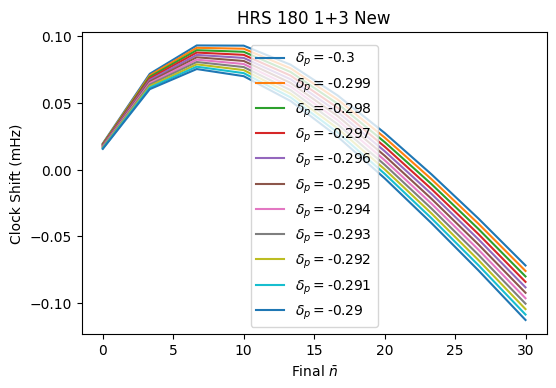

In [10]:
plt.figure(figsize=(6,4), dpi=100)

for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 3) ))
    maxshift = np.max(np.abs(1e3*results[ii,:]/(2.0*np.pi)))
    print(r'$\delta_p = $' + str(round(delPrimes[ii]/(2.0*np.pi), 3) ) + ", max shift = "+ str(maxshift))
plt.legend()
plt.title("HRS 180 1+3 New")
plt.ylabel("Clock Shift (mHz)")
plt.xlabel(r"Final $\bar{n}$")
plt.show()

# N_cut convergence test

In [53]:
Ncuts = np.array([10, 50, 100, 200, 300, 400, 500, 700, 900,2000])
NcutPts = np.size(Ncuts)

nbarfPts = 25
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([NcutPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
delPrime = -0.3*2.*np.pi

for ii in range(NcutPts):
    results[ii,:] = shiftCurve(HRJumpNewc, t1, T, t2, delPrime, delPrime, Omega0, nbarfs, Ncuts[ii])

0.00012278995872924998
[-4.999877210041271, 5.000122789958729]
0.0003413664956044798
[-4.999658633504396, 5.000341366495604]
0.0004384867135143381
[-4.999561513286485, 5.000438486713515]
0.00048357016215508846
[-4.999516429837845, 5.000483570162155]
0.0005086926116165919
[-4.999491307388383, 5.000508692611617]
0.000524548827332448
[-4.999475451172668, 5.000524548827332]
0.0005354250155690173
[-4.999464574984431, 5.000535425015569]
0.0005433345175957834
[-4.999456665482405, 5.000543334517595]
0.0005493396879064584
[-4.999450660312093, 5.000549339687907]
0.0005540517354128989
[-4.999445948264587, 5.000554051735413]
0.0005578464240014791
[-4.999442153575998, 5.000557846424002]
0.0005609671737682476
[-4.999439032826232, 5.000560967173768]
0.0005635784762899398
[-4.99943642152371, 5.00056357847629]
0.0005657954235573168
[-4.999434204576443, 5.000565795423557]
0.0005677009257942182
[-4.999432299074206, 5.000567700925794]
0.0005693562080469103
[-4.999430643791953, 5.000569356208047]
0.0005708

2.09879226406229e-06
[-4.999997901207736, 5.000002098792264]
-0.00012588204151360913
[-5.000125882041513, 4.999874117958487]
-0.00025853335529328093
[-5.000258533355293, 4.999741466644707]
-0.00039596148830807216
[-5.000395961488308, 4.999604038511692]
-0.000538655601038538
[-5.000538655601039, 4.999461344398961]
-0.0006873337202653114
[-5.000687333720266, 4.999312666279734]
-0.0008428221662747427
[-5.000842822166275, 4.999157177833725]
-0.0010059643899182934
[-5.001005964389918, 4.998994035610082]
-0.0011775547303334482
[-5.001177554730334, 4.998822445269666]
-0.0013582927316746142
[-5.001358292731674, 4.998641707268326]
-0.0015487540514821634
[-5.001548754051482, 4.998451245948518]
-0.0017493744738249603
[-5.001749374473825, 4.998250625526175]
-0.001960444028925928
[-5.001960444028926, 4.998039555971074]
-0.0021821086842264362
[-5.002182108684226, 4.997817891315774]
0.00012278995872924998
[-4.999877210041271, 5.000122789958729]
0.00035436804265901313
[-4.999645631957341, 5.0003543680

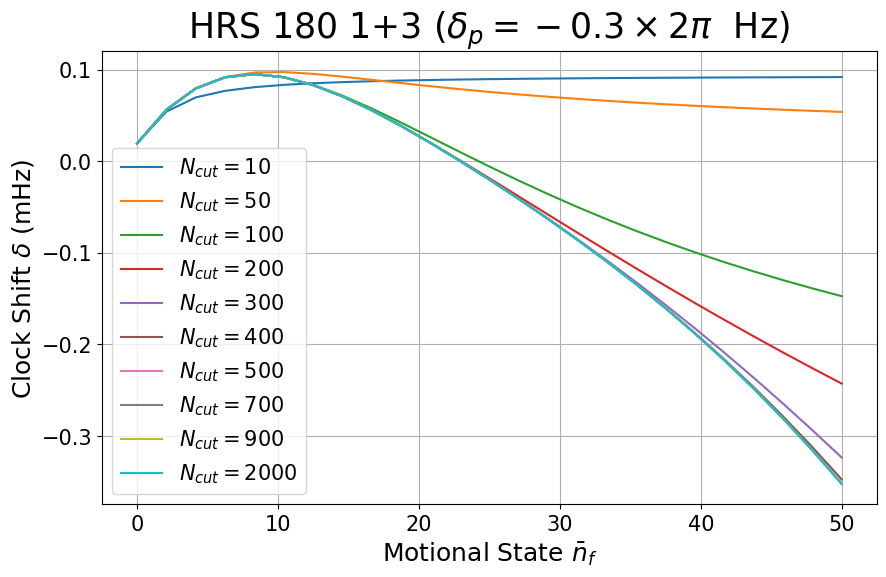

In [54]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(NcutPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$N_{cut} = $" + str(Ncuts[ii]) )
plt.legend(fontsize="15")
plt.title(r"HRS 180 1+3 ($\delta_p = -0.3 \times 2\pi \ $ Hz)",fontsize="25")
plt.ylabel("Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n}_f$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.show()

In [55]:
maxErr=0
for ii in range(nbarfPts):
    err = np.abs((results[6,ii]-results[9,ii])/results[9,ii])
    if err > maxErr: maxErr=err
print(maxErr*100)

0.18244167111115064


# Sensitive sequence test

In [23]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1.0,1.0, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*t1)
Ncut = 500

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRNew, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.002508555969379571
[-5.00250855596938, 4.99749144403062]
-0.11527703380292884
[-5.115277033802929, 4.884722966197071]
-0.2775320234887667
[-5.277532023488766, 4.722467976511234]
-0.49338620046832327
[-5.493386200468323, 4.506613799531677]
-0.7710633530569562
[-5.771063353056956, 4.228936646943044]
-1.1251345364387924
[-6.125134536438792, 3.874865463561208]
-1.5786275143544635
[-6.578627514354464, 3.4213724856455365]
-2.1610439304518
[-7.1610439304518, 2.8389560695482]
-2.8950845705381227
[-7.895084570538122, 2.1049154294618773]
-3.7643895454726524
[-8.764389545472653, 1.2356104545273476]
-0.003630169415684106
[-5.003630169415684, 4.996369830584316]
-0.09526304204989085
[-5.095263042049891, 4.904736957950109]
-0.22762489801739083
[-5.227624898017391, 4.772375101982609]
-0.4052916575165779
[-5.405291657516578, 4.594708342483422]
-0.6374955207435815
[-5.637495520743581, 4.362504479256419]
-0.9413327893209871
[-5.941332789320987, 4.058667210679013]
-1.3466628984592164
[-6.34666289845921

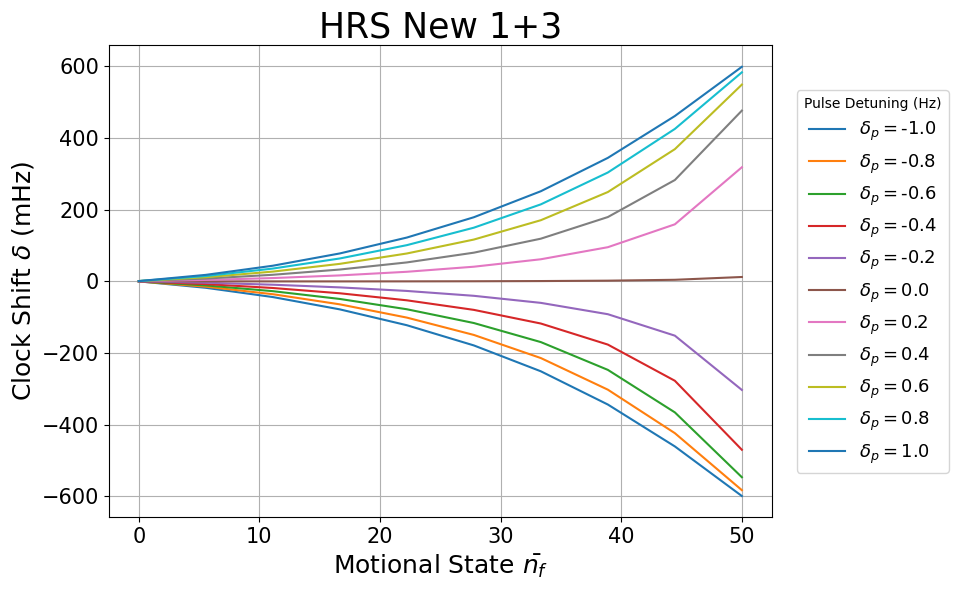

In [24]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS New 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [20]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1.0,1.0, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 5.0*t1
Omega0 = np.pi/(2.*t1)
Ncut = 500

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRNew, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.5291874041047314
[-4.470812595895269, 5.529187404104731]
0.47494880339333295
[-4.525051196606667, 5.474948803393333]
0.5259982526260846
[-4.474001747373915, 5.525998252626085]
0.7429532319200911
[-4.257046768079909, 5.742953231920091]
1.1877525786529544
[-3.8122474213470454, 6.187752578652955]
1.8344589313730633
[-3.1655410686269367, 6.834458931373064]
2.4999376177258257
[-2.5000623822741743, 7.499937617725825]
2.9903467530239607
[-2.0096532469760393, 7.99034675302396]
3.266937594142624
[-1.733062405857376, 8.266937594142624]
3.3877617978547323
[-1.6122382021452677, 8.387761797854733]
0.42181778077818305
[-4.578182219221817, 5.421817780778183]
0.37868607579099794
[-4.621313924209002, 5.378686075790998]
0.4214818865681113
[-4.578518113431889, 5.421481886568111]
0.6018490461917901
[-4.3981509538082095, 5.6018490461917905]
0.9756519969895185
[-4.0243480030104815, 5.9756519969895185]
1.5332696045073706
[-3.4667303954926294, 6.533269604507371]
2.131030363315239
[-2.868969636684761, 7.1310

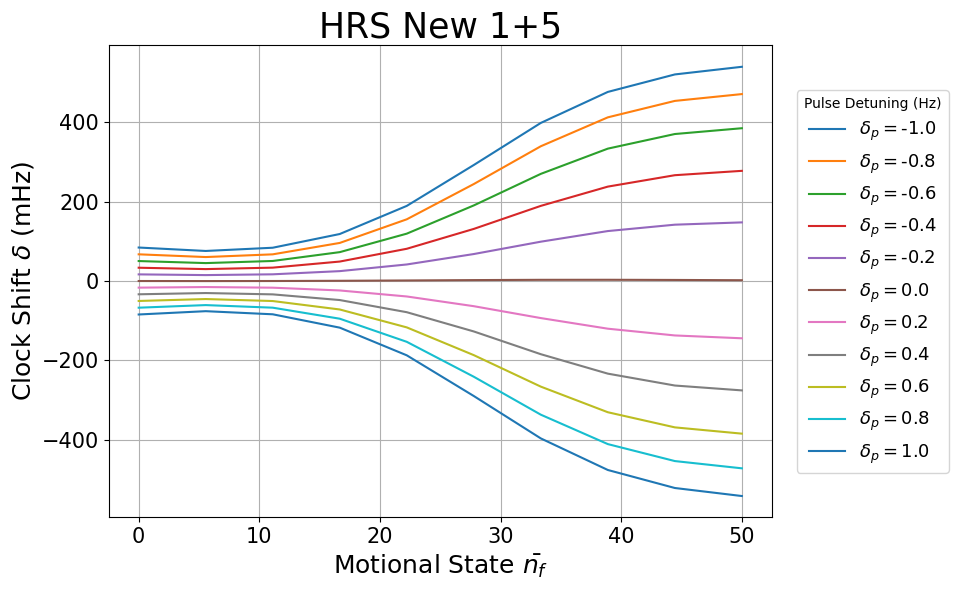

In [21]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS New 1+5",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [11]:
delPts = 1
delPrimes = 2.0*np.pi*1.0#np.linspace(-1.0,1.0, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 150, nbarfPts)
results = np.zeros([delPts, nbarfPts])
results2 = np.zeros([delPts, nbarfPts])

t1 = 20e-3
T = 300e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*t1)
Ncut = 500

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRNew, t1, T, t2, delPrimes, delPrimes, Omega0, nbarfs, Ncut)
    results2[ii,:] = shiftCurve(HRNew, t1, T, t2, -delPrimes, -delPrimes, Omega0, nbarfs, Ncut)

-0.00541219289759861
[-5.005412192897599, 4.994587807102401]
-0.0054263348677357865
[-5.005426334867736, 4.994573665132264]
-0.005424870373208033
[-5.005424870373208, 4.994575129626792]
-0.005407381989723506
[-5.005407381989723, 4.994592618010277]
-0.00537345717967508
[-5.005373457179675, 4.994626542820325]
-0.005322688700212348
[-5.005322688700212, 4.994677311299788]
-0.005254679716555943
[-5.005254679716556, 4.994745320283444]
-0.005169075474319319
[-5.00516907547432, 4.99483092452568]
-0.005065654106201758
[-5.005065654106202, 4.994934345893798]
-0.004944469551850077
[-5.00494446955185, 4.99505553044815]
-0.0048059861410013685
[-5.004805986141001, 4.995194013858999]
-0.004651143615283195
[-5.004651143615283, 4.995348856384717]
-0.004481333181565091
[-5.004481333181565, 4.995518666818435]
-0.004298304177988425
[-5.004298304177988, 4.995701695822012]
-0.00410403638019096
[-5.004104036380191, 4.995895963619809]
-0.0039006095011659293
[-5.003900609501166, 4.996099390498834]
-0.003690090

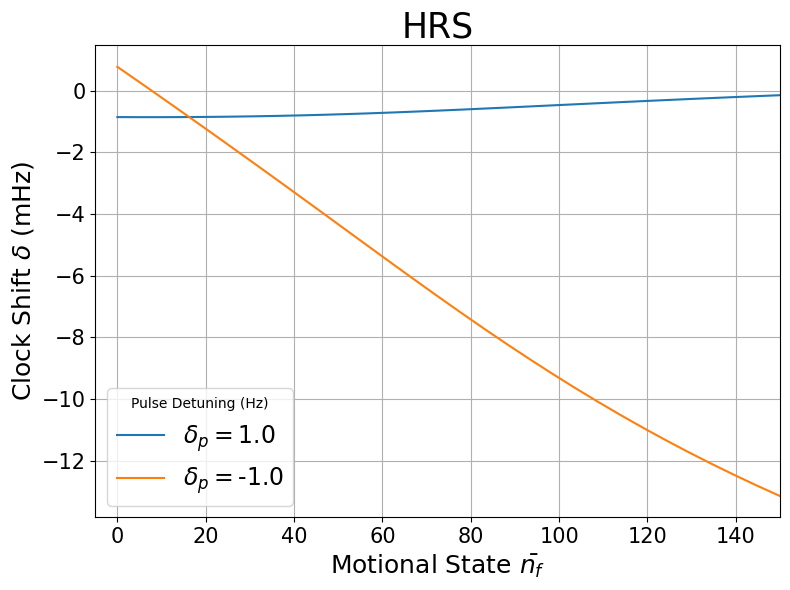

In [12]:
plt.figure(figsize=(8,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
    plt.plot(nbarfs, 1e3*results2[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(-delPrimes/(2.0*np.pi), 1)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.xlim([-5,150])
#plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.legend(title=r"Pulse Detuning (Hz)",fontsize="17")
plt.tight_layout()
plt.show()

In [50]:
dopAndStarks[20]

-0.011906769571438679

In [12]:
0.088e-3/642121496772645.13

1.3704571555740644e-19

In [13]:
1.209e-3/642121496772645.13

1.88282125123755e-18